<a href="https://colab.research.google.com/github/anogassis/aisf-project/blob/eda-notebooks/notebooks/1.1-aa-tms-experiments_tassilo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy Models of Superposition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/tms.ipynb)

Let's run through an example using Anthropic's toy models of superposition.

This example is mostly to test that our SGLD estimator is working as expected and to figure out how to integrate this in an SGD setting.

Credits: [Chen et al. (2023)](https://arxiv.org/abs/2310.06301).

## Set-up


### Imports

In [15]:
%pip install devinterp scipy pyyaml pandas

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [185]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from typing import Iterable, Optional, Callable, Dict, List, Any
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from torch.utils.data import DataLoader
from tqdm import tqdm
import itertools
from torch.utils.data import TensorDataset
from torch.nn import functional as F
from devinterp.slt import estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD
from collections import defaultdict


#from google.colab import drive
#drive.mount('/content/drive')


### Toy Models & Data Generation

In [38]:
class ToyAutoencoder(nn.Module):
    """
    Basic Network class for linear transformation with non-linear activations
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        n_instances: int = 1,
        tied: bool = True,
        final_bias: bool = False,
        hidden_bias: bool = False,
        nonlinearity: Callable = F.relu,
        unit_weights: bool = False,
        standard_magnitude: bool = False,
        initial_scale_factor: float = 1.0,
        initial_bias: Optional[torch.Tensor] = None,
        initial_embed: Optional[torch.Tensor] = None,
    ):
        super().__init__()

        # Set the dimensions and parameters
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_instances = n_instances
        self.nonlinearity = nonlinearity
        self.tied = tied
        self.final_bias = final_bias
        self.unit_weights = unit_weights
        self.standard_magnitude = standard_magnitude

        # Define the input layer (embedding)
        self.embedding = nn.Linear(self.input_dim, self.hidden_dim, bias=hidden_bias)

        # Set initial embeddings if provided
        if initial_embed is not None:
            self.embedding.weight.data = initial_embed

        # Define the output layer (unembedding)
        self.unembedding = nn.Linear(self.hidden_dim, self.input_dim, bias=final_bias)

        # Set initial bias if provided
        if initial_bias is not None:
            self.unembedding.bias.data = initial_bias

        # If standard magnitude is set, normalize weights and maintain average norm
        if self.standard_magnitude:
            avg_norm = torch.norm(self.embedding.weight.data, p=2, dim=0).mean()
            self.embedding.weight.data = (
                F.normalize(self.embedding.weight.data, p=2, dim=0) * avg_norm
            )

        # If unit weights is set, normalize weights
        if self.unit_weights:
            self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=0)

        # Tie the weights of embedding and unembedding layers
        if tied:
            self.unembedding.weight = torch.nn.Parameter(self.embedding.weight.transpose(0, 1))


    def forward(self, x: torch.Tensor):
        """
        Forward pass through the network
        """
        # Apply the same steps for weights as done during initialization
        if self.unit_weights:
            self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=0)

        if self.standard_magnitude:
            avg_norm = torch.norm(self.embedding.weight.data, p=2, dim=0).mean()
            self.embedding.weight.data = (
                F.normalize(self.embedding.weight.data, p=2, dim=0) * avg_norm
            )

        if self.tied:
            self.unembedding.weight.data = self.embedding.weight.data.transpose(0, 1)

        x = self.embedding(x)
        x = self.unembedding(x)
        x = self.nonlinearity(x)

        return x


In [39]:
"""
Adapted from [TMS-zoo](https://github.com/JakeMendel/TMS-zoo)
"""

from abc import ABC
from typing import Union

import torch
from torch.utils.data import Dataset


class SyntheticDataset(Dataset, ABC):
    num_samples: int
    num_features: int
    sparsity: Union[float, int]
    # importance: Optional[float]

    def __init__(
        self,
        num_samples,
        num_features,
        sparsity,
        # importance=None
    ):
        """
        Initialize the  object.

        Args:
            num_samples: The number of samples to generate.
            num_features: The dimension of the feature vector.
            sparsity: (float) the probability that a given feature is zero or (int) the number of features that are set to one.
            importance: The importance of the features. If None, then the features are weighted uniformly.
                        Otherwise, the features are weighted by `importance ** (1 + i)`, where `i` is the index of the feature.
        """
        self.num_samples = num_samples  # The number of samples in the dataset
        self.num_features = num_features  # The size of the feature vector for each sample
        self.sparsity = sparsity
        # self.importance = importance
        self.data = self.generate_data()  # Generate the synthetic data

    def generate_values(self):
        raise NotImplementedError

    def generate_mask(self):
        """
        Generate a sparse mask for the given dataset.

        If ``sparsity`` is a float, then the mask is generated by sampling from a Bernoulli distribution with parameter ``1 - sparsity``.
        If ``sparsity`` is an integer, then the mask is generated by sampling exactly ``sparsity`` indices without replacement.

        Args:
            dataset: The dataset to generate the mask for.

        Returns:
            A sparse mask for the given dataset.
        """

        if isinstance(self.sparsity, float):
            return torch.bernoulli(
                torch.ones((self.num_samples, self.num_features)) * (1 - self.sparsity)
            )
        elif isinstance(self.sparsity, int):
            mask = torch.zeros((self.num_samples, self.num_features))
            for i in range(self.num_samples):
                indices = torch.randperm(self.num_features)[: self.sparsity]
                mask[i, indices] = 1

            return mask

        else:
            raise ValueError(
                f"Sparsity must be a float or an integer. Received {type(self.sparsity)}."
            )

    def generate_data(self):
        return self.generate_mask() * self.generate_values()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]


class SyntheticUniformValued(SyntheticDataset):
    """
    This class creates a synthetic dataset where each sample is a vector which has indices which are zero with probability sparsity and uniform between 0 and 1 otherwise
    """

    def generate_values(self):
        return torch.rand((self.num_samples, self.num_features))


class SyntheticBinaryValued(SyntheticDataset):
    """
    This class creates a synthetic dataset where each sample is a vector which has indices which are zero with probability ``sparsity`` and 1 otherwise
    """

    def generate_values(self):
        return 1.0


In [196]:
def calculate_convex_hull_vertices(W: torch.Tensor) -> int:
    """
    Calculate the number of vertices of the convex hull of the points represented by the columns of W.
    
    Parameters:
    W (torch.Tensor): A 2xN matrix where each column represents a point in 2D space.
    
    Returns:
    int: The number of vertices of the convex hull.
    """
    if W.shape[0] != 2:
        raise ValueError("The weight matrix W must have 2 rows.")
    
    # Convert the tensor to a numpy array if it isn't already
    if isinstance(W, torch.Tensor):
        W = W.cpu().detach().numpy()
    
    hull = ConvexHull(W.T)
    return len(hull.vertices)  # The number of vertices is the same as the number of edges

def count_kgons(W: List[Dict[str, Any]]) -> Dict[int, int]:
    edge_counts = {}
    
    # Process each weight matrix
    for full_w in W:
        num_edges = classify_kgon(full_w)
        if num_edges in edge_counts:
            edge_counts[num_edges] += 1
        else:
            edge_counts[num_edges] = 1

    return edge_counts

def classify_5_gon(W: np.ndarray, b: np.ndarray) -> Any:
    """
    Classify a 5-gon based on the weights and biases. 
    """
    if W.shape[0] == 2:
        W = W.T

    # Compute the convex hull
    hull = ConvexHull(W)
    
    # Check if the number of vertices is equal to 5
    if len(hull.vertices) != 5:
        return "not a 5-gon"
    
    # Check if any of the non-vertex biases are large negative
    non_vertex_biases = np.delete(b, hull.vertices)

    # Check for any positive bias that is not part of the convex hull vertices
    non_hull_positive_bias = np.any(non_vertex_biases > 0)

    if not non_hull_positive_bias:
        return 5
    elif non_hull_positive_bias:
        return "5+"
    else:
        return 'not a 5-gon'

def classify_kgon(W: Dict[str, torch.Tensor]) -> int:
    embedding_w = W["embedding.weight"]
    edges = calculate_convex_hull_vertices(embedding_w)
    if edges == 5:
        return classify_5_gon(embedding_w, W["unembedding.bias"])
    return edges

def compute_kgon_percentages(weights: Dict[int, List[List[Dict[str, torch.Tensor]]]], steps: List[int], k_values: List[int] = [5, 6]) -> Dict[int, Dict[int, List[float]]]:
    sparsities = sorted(weights.keys())
    
    # Create a dictionary to store percentages of k-gons for each sparsity
    kgon_percentages = {sparsity: {k: [] for k in k_values} for sparsity in sparsities}
    
    # Iterate over each sparsity
    for sparsity, runs_weights in weights.items():
        # Iterate over each time step
        for step_weights in zip(*runs_weights):  # This transposes the list of lists
            edge_counts = count_kgons(step_weights)
            total_counts = sum(edge_counts.values())
            
            # Calculate percentages for interested k-gons
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[sparsity][k].append(percentage)
        
        # Plot the percentage of k-gons over time for each k-value
        percentages = np.zeros(len(steps))
        for k in k_values:
            percentages += kgon_percentages[sparsity][k][:-1]  # fixme: reduced length by one but not sure why this is longer?
    return kgon_percentages

def plot_percentage_of_kgons_over_time(weights: Dict[int, List[List[Dict[str, torch.Tensor]]]], steps: List[int], k_values: List[int] = [5, 6], xscales: str = "log", yscales: str = "linear", plot: bool = True, title: str = None) -> None:
    plt.figure(figsize=(15, 6))
    
    # Generate a color map to represent different sparsities with a color gradient
    sparsities = sorted(weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(sparsities)))
    
    # Create a dictionary to store percentages of k-gons for each sparsity
    kgon_percentages = {sparsity: {k: [] for k in k_values} for sparsity in sparsities}
    
    # Iterate over each sparsity
    for sparsity, runs_weights in weights.items():
        # Get the color for the current sparsity
        color = colors[sparsities.index(sparsity)]
        
        # Iterate over each time step
        for step_weights in zip(*runs_weights):  # This transposes the list of lists
            edge_counts = count_kgons(step_weights)
            total_counts = sum(edge_counts.values())
            
            # Calculate percentages for interested k-gons
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[sparsity][k].append(percentage)
        
        # Plot the percentage of k-gons over time for each k-value
        percentages = np.zeros(len(steps))
        for k in k_values:
            percentages += kgon_percentages[sparsity][k][:-1]  # fixme: reduced length by one but not sure why this is longer?
        label = f'Sparsity: {sparsity}, {" ".join([str(k) for k in k_values])}-gons'
        plt.plot(steps, percentages, label=label, color=color)

    plt.xlabel('Step')
    plt.ylabel('Percentage of k-gons')
    plt.xscale(xscales)
    plt.yscale(yscales)
    if not title:
        plt.title(f'Percentage of {", ".join([str(k) for k in k_values])}-gons over Training Steps for Different Sparsities')
    else: 
        plt.title(title)
    plt.legend()

def plot_rate_of_change_of_kgons(weights: Dict[int, List[List[Dict[str, torch.Tensor]]]], steps: List[int], k_values: List[int] = [5, 6], xscale: str = 'log') -> None:
    plt.figure(figsize=(15, 6))
    
    sparsities = sorted(weights.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(sparsities)))
    
    kgon_percentages = {sparsity: {k: [] for k in k_values} for sparsity in sparsities}
    kgon_rate_of_change = {sparsity: {k: [] for k in k_values} for sparsity in sparsities}
        
    rate_of_change = np.zeros(len(steps) - 1)
    
    for sparsity, runs_weights in weights.items():
        color = colors[sparsities.index(sparsity)]
        
        for step_weights in zip(*runs_weights):
            edge_counts = count_kgons(step_weights)
            total_counts = sum(edge_counts.values())
            
            for k in k_values:
                percentage = (edge_counts.get(k, 0) / total_counts) * 100
                kgon_percentages[sparsity][k].append(percentage)
        
        for k in k_values:
            kgon_rate_of_change[sparsity][k] = np.diff(kgon_percentages[sparsity][k])
        
        for k in k_values:
            rate_of_change += kgon_rate_of_change[sparsity][k]
        label = f'Sparsity: {sparsity}, {" ".join([str(k) for k in k_values])}-gons Rate of Change'
    plt.plot(steps[1:], rate_of_change, label=label, color=color)
    
    plt.xlabel('Step')
    plt.ylabel('Rate of Change of Percentage of k-gons')
    plt.xscale(xscale)
    plt.title(f'Rate of Change of {", ".join([str(k) for k in k_values])}-gons over Training Steps for Different Sparsities')
    plt.legend()
    plt.show()


### Environmental variables

In [40]:
torch.manual_seed(1)

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

### K-gon Plotting Utils

In [41]:
def generate_2d_kgon_vertices(k, rot=0., pad_to=None, force_length=0.9):
    """Set the weights of a 2D k-gon to be the vertices of a regular k-gon."""
    # Angles for the vertices
    theta = np.linspace(0, 2*np.pi, k, endpoint=False) + rot

    # Generate the vertices
    x = np.cos(theta)
    y = np.sin(theta)
    result = np.vstack((x, y))

    if pad_to is not None and k < pad_to:
        num_pad = pad_to - k
        result = np.hstack([result, np.zeros((2, num_pad))])

    return (result * force_length)

def generate_init_param(m, n, init_kgon, prior_std=1., no_bias=True, init_zerobias=True, seed=0, force_negb=False, noise=0.01):
    np.random.seed(seed)

    if init_kgon is None or m != 2:
        init_W = np.random.normal(size=(m, n)) * prior_std
    else:
        assert init_kgon <= n
        rand_angle = np.random.uniform(0, 2 * np.pi, size=(1,))
        noise = np.random.normal(size=(m, n)) * noise
        init_W = generate_2d_kgon_vertices(init_kgon, rot=rand_angle, pad_to=n) + noise

    if no_bias:
        param = {"W": init_W}
    else:
        init_b = np.random.normal(size=(n, 1)) * prior_std
        if force_negb:
            init_b = -np.abs(init_b)
        if init_zerobias:
            init_b = init_b * 0
        param = {
            "W": init_W,
            "b": init_b
        }
    return param

In [197]:
def plot_polygon(
    W: torch.Tensor,
    b=None,
    ax=None,
    ax_bias=None,
    ax_wnorm=None,
    hull_alpha=0.3,
    dW=None,
    dW_scale=0.3,
    orderb=True,
    color="b",
):
    """Credits: Edmund Lau"""
    if ax is None:
        if W.shape[0] == 2:
            fig, ax = plt.subplots(1, 1)
        elif W.shape[0] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")

    if W.shape[0] == 2:  # 2D case
        # Compute the norms of the columns
        norms = np.linalg.norm(W, axis=0)

        # Normalize a copy of the vectors for angle calculations
        W_normalized = W / norms

        # Compute angles from the x-axis for each vector
        angles = np.arctan2(W_normalized[1, :], W_normalized[0, :])

        # Sort the columns of W by angles
        order = np.argsort(angles)
        W_sorted = W[:, order]

        # Plot the origin
        ax.scatter(0, 0, color="red")

        # Plot the vectors
        for i in range(W_sorted.shape[1]):
            ax.quiver(
                0,
                0,
                W_sorted[0, i],
                W_sorted[1, i],
                angles="xy",
                scale_units="xy",
                scale=1,
                width=0.003,
            )
        if dW is not None:
            dW = -dW_scale * dW / np.max(np.linalg.norm(dW, axis=0))
            for col in range(W.shape[1]):
                ax.quiver(
                    W[0, col],
                    W[1, col],
                    dW[0, col],
                    dW[1, col],
                    angles="xy",
                    scale_units="xy",
                    scale=1,
                    color="r",
                    width=0.005,
                )

        # Connect the vectors to form a polygon
        polygon = np.column_stack((W_sorted, W_sorted[:, 0]))
        ax.plot(polygon[0, :], polygon[1, :], alpha=0.5)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        vs = list(hull.vertices) + [hull.vertices[0]]
        ax.plot(W[0, vs], W[1, vs], "r--", alpha=hull_alpha)

        # Set the aspect ratio of the plot to equal to ensure that angles are displayed correctly
        ax.set_aspect("equal", adjustable="box")

    elif W.shape[0] == 3:  # 3D case
        # Plot the origin
        ax.scatter([0], [0], [0], color="red")

        # Plot the vectors
        for i in range(W.shape[1]):
            ax.plot([0, W[0, i]], [0, W[1, i]], [0, W[2, i]], color)

        # Plot the convex hull
        hull = ConvexHull(W.T)
        for s in hull.simplices:
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            ax.plot(W[0, s], W[1, s], W[2, s], "r--", alpha=hull_alpha)
    else:
        raise ValueError("W must have either 2 or 3 rows")

    if b is not None and ax_bias is not None and W.shape[0]==2:
        
        b_plot = np.ravel(b)
        if orderb:
            b_plot = b_plot[order]
        bar_colors = ["r" if val < 0 else "g" for val in b_plot]
        yticks = np.array(range(1, len(b_plot) + 1))
        ax_bias.barh(
            yticks - 0.4,
            np.abs(b_plot),
            height=0.4,
            color=bar_colors,
            align="edge",
        )
        ax_bias.set_yticks(yticks)
        ax_bias.yaxis.tick_right()
        ax_bias.tick_params(axis="y", labelsize="x-small")
        ax_bias.tick_params(axis="x", labelsize="x-small")

    if ax_wnorm is not None and W.shape[0]==2:
        yticks = np.array(range(1, W.shape[1] + 1))
        wnorms = np.linalg.norm(W, axis=0)
        if orderb:
            wnorms = wnorms[order]
        ax_wnorm.barh(yticks, width=wnorms, height=0.4, color="black", alpha=0.9, align="edge")
    return ax


def plot_polygons(Ws, biases, axes=None,ax_biases=None):
    if axes is None:
        fig, axes = plt.subplots(1, len(Ws), figsize=(15, 4))
    if ax_biases is None:
        fig, ax_biases = plt.subplots(1, len(Ws), figsize=(15, 4))

    for ax, W,ax_b,b in zip(axes, Ws, ax_biases,biases):
        plot_polygon(W,b=b, ax=ax, ax_bias=ax_b,ax_wnorm=ax_b)


def plot_losses_and_polygons(steps, losses, highlights, Ws, biases,xscale="log", yscale="log",batch_size=None, run=None, version = None):
    fig = plt.figure(figsize=(15, 6))

    gs = fig.add_gridspec(3, len(Ws))
    ax_losses = fig.add_subplot(gs[2, :])
    ax_polygons = []
    ax_biases = []
    

    max_x, min_x = max([np.max(W[0]) for W in Ws]), min([np.min(W[0]) for W in Ws])
    max_y, min_y = max([np.max(W[1]) for W in Ws]), min([np.min(W[1]) for W in Ws])

    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[0, i], adjustable='box') 
        ax.set_aspect('equal')
        ax_polygons.append(ax)
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y+0.5)
    for i in range(len(Ws)):
        ax = fig.add_subplot(gs[1, i], adjustable='box')
        ax_biases.append(ax)
        ax.set_xlim(0, 1.5)
        #ax.set_ylim(0, 1.5)
        
        
        
    ax_losses.plot(steps, losses)
    ax_losses.set_xlabel("Step")
    ax_losses.set_ylabel("Loss")
    ax_losses.set_xscale(xscale)
    ax_losses.set_yscale(yscale)

    for i, step in enumerate(highlights):
        ax_losses.axvline(step, color="gray", linestyle="--")

    plot_polygons(Ws,biases,ax_polygons, ax_biases=ax_biases)
    version_str = f"Version: {version}" if version is not None else ""
    batch_size_str = f"Batch size: {batch_size}" if batch_size is not None else ""
    run_str = f"Run: {run}" if run is not None else ""
    plt.suptitle("Loss and Weight snapshots, " + batch_size_str + " " + run_str+ " " + version_str)
    plt.tight_layout()


### Training loop

In [43]:
def create_and_train(
    m: int,
    n: int,
    num_samples: int,
    batch_size: Optional[int] = 1,
    num_epochs: int = 100,
    sparsity: Union[float, int] = 1,
    lr: float = 0.001,
    log_ivl: Iterable[int] = [],
    device=DEVICE,
    momentum=0.9,
    weight_decay=0.0,
    init_kgon=None,
    no_bias=False,
    init_zerobias=False,
    prior_std=10.,
    seed=0
):
    torch.manual_seed(seed)

    model = ToyAutoencoder(m, n, final_bias=True)

    init_weights = generate_init_param(n, m, init_kgon, no_bias=no_bias, init_zerobias=init_zerobias, prior_std=prior_std, seed=seed)
    model.embedding.weight.data = torch.from_numpy(init_weights["W"]).float()

    if "b" in init_weights:
        model.unembedding.bias.data = torch.from_numpy(init_weights["b"].flatten()).float()

    dataset = SyntheticBinaryValued(num_samples, m, sparsity)
    batch_size = batch_size

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    logs = pd.DataFrame([{"loss": None, "acc": None, "step": step} for step in log_ivl])

    model.to(device)
    weights = []

    def log(step):
        loss = 0.0
        acc = 0.0
        length = 0

        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(device)
                outputs = model(batch)
                loss += criterion(outputs, batch).item() * len(batch) # adding "* len(batch)"
                acc += (outputs.round() == batch).float().sum().item()
                length += len(batch)

        loss /= length
        acc /= length

        logs.loc[logs["step"] == step, ["loss", "acc"]] = [loss, acc]
        weights.append({k: v.cpu().detach().clone().numpy() for k, v in model.state_dict().items()})

    step = 0
    log(step)

    for epoch in tqdm(range(num_epochs), desc="Training"):
        for batch in dataloader:
            batch = batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            step += 1

            if step in log_ivl:
                log(step)

    return logs, weights

## Training

## Analysis

## Design of Experiments

First, let's list the variables we can play with:
- Sparsity
- Number of samples
- Number of input features
- Number of hidden features

### Variable ranges

Let's now define the ranges we want to explore for each of the variables we're interested in.

| Variable | Lower limit | Upper limit | Stepsize | Number of variations |
| -------- | ----------- | ----------- | -------- | --- |
| Sparsity | 0.0 | 1.0 | 0.25 | 5 |
| Number of samples | 100 | 10000 | Log 10 | 3 |
| Number of input features | 6 | 14 | 2 | 5 |
| Number of hidden features | 2 | 3 | 1 | 2 |

Total number of experiments if performing a full factorial: `5 * 3 * 5 * 2 = 150`

In [202]:
training_dict = {
    "m": [6],
    "n": [2],
    "num_samples": [100,1000],
    "batch_size": [300],
    "num_epochs": [20000],
    "sparsity": [0.1, 0.25, 0.50, 0.75,0.9, 1],
    "lr": [0.005],
    "momentum": [0.9],
    "weight_decay": [0.0],
    "init_kgon": [4],
    "no_bias": [False],
    "init_zerobias": [False],
    "prior_std": [10.],
    "seed": [i for i in range(30)],
}

test_dict = {
    "m": [6],
    "n": [2],
    "num_samples": [100],
    "batch_size": [300],
    "num_epochs": [2000],
    "sparsity": [1],
    "lr": [0.001],
    "momentum": [0.9],
    "weight_decay": [0.0],
    "init_kgon": [4],
    "no_bias": [False],
    "init_zerobias": [False],
    "prior_std": [10.],
    "seed": [42]
}

### Train all models

In [203]:
def run_experiments(
    training_dict: Dict[str, List[Any]],
    train_func: Callable[[Dict[str, Any]], Any],
    save: bool = False,
    file_name: str = None
    ) -> List[Dict[str, Any]]:
    """
    Runs experiments for all combinations of parameters in the training dictionary,
    with an incremental run_id starting at 0.

    Parameters
    ----------
    training_dict : dict
        A dictionary where keys are parameter names and values are lists of parameter values.
    train_func : callable
        A function that takes a dictionary of parameters and returns the result of the training.

    Returns
    -------
    List[dict]
        A list of dictionaries, each containing the run_id, parameters used, and the result of the training.
    """
    # Extract parameter names and their values
    param_names = list(training_dict.keys())
    param_values = [training_dict[name] for name in param_names]

    # Generate all combinations of parameters
    combinations = list(itertools.product(*param_values))

    # Store results
    results = []

    # Iterate through each combination
    for run_id, combination in enumerate(combinations):
        pkl_file_name = file_name + '_' + str(run_id) + '.pkl'
        if os.path.exists(pkl_file_name):
            continue
        params = dict(zip(param_names, combination))

        # Calculate `log_ivl` based on `num_epochs`
        num_epochs = params.get('num_epochs', 100)
        num_observations = 50  # As per example
        steps = sorted(list(set(np.logspace(0, np.log10(num_epochs), num_observations).astype(int))))
        params['log_ivl'] = steps

        logs, weights = train_func(**params)
        run_result = {
            "run_id": run_id,
            "parameters": params,
            "logs": logs,
            "weights": weights
        }
        results.append(run_result)

        if save:
            with open(pkl_file_name, 'wb') as file:
                pickle.dump(results, file)
        results=[]
    if save:
        with open(file_name + 'all_runs', 'wb') as file:
            pickle.dump(results, file)

    return results

def plot_experiments(
    results: List[Dict[str, Any]],
    show:bool = True,
    save: bool = False,
    file_name: str = None
    ) -> None:
    """
    Plots the results of the experiments using plot_losses_and_polygons.

    Parameters
    ----------
    results : List[dict]
        A list of dictionaries, each containing the run_id, parameters used, logs, and weights.
    """
    for result in results:
        run_id = result['run_id']
        params = result['parameters']
        logs = result['logs']
        weights = result['weights']

        # Extract steps and losses from logs
        steps = list(logs['step'].values)
        losses = list(logs['loss'].values)

        # Generate highlight steps based on the number of epochs
        num_epochs = params.get('num_epochs', 100)
        num_observations = 50
        plot_steps = [min(steps, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, num_epochs - 1]]
        plot_indices = [steps.index(s) for s in plot_steps]

        # Extract weights at the highlight steps
        Ws = [weights[i]['embedding.weight'] for i in plot_indices]

        # Plot losses and polygons
        plt.figure()
        plot_losses_and_polygons(steps, losses, plot_steps, Ws)

        # Title the plot based on parameters
        keys_in_title = ['run_id','m', 'n' ,'num_samples', 'batch_size', 'sparsity', 'lr']
        title = ', '.join(f'{key}: {value}' for key, value in params.items() if key in keys_in_title)
        plt.suptitle(f'Run ID: {run_id}\n {title}')
        plt.tight_layout()

        if show:
            plt.show()

        if save:
            plt.savefig(f'{file_name}_{run_id}.png')

        plt.close()


In [204]:
# Run experiments
version = "v1.1.0"
file_name = f'../data/logs_loss_{version}'

In [ ]:
results = run_experiments(
    training_dict,
    create_and_train,
    save=False,
    file_name=file_name
    )

Training:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18348/20000 [00:33<00:02, 602.05it/s]

In [133]:
# Load experiments
version = "v1.0.0"
file_name = f'../data/logs_loss_{version}'

In [143]:
results = []
for run_id in range(0, 855):
    with open(f'{file_name}_{run_id}.pkl', "rb") as file:
        results.append(pickle.load(file)[-1])

/tmp/ipykernel_616374/3456984189.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15, 6))


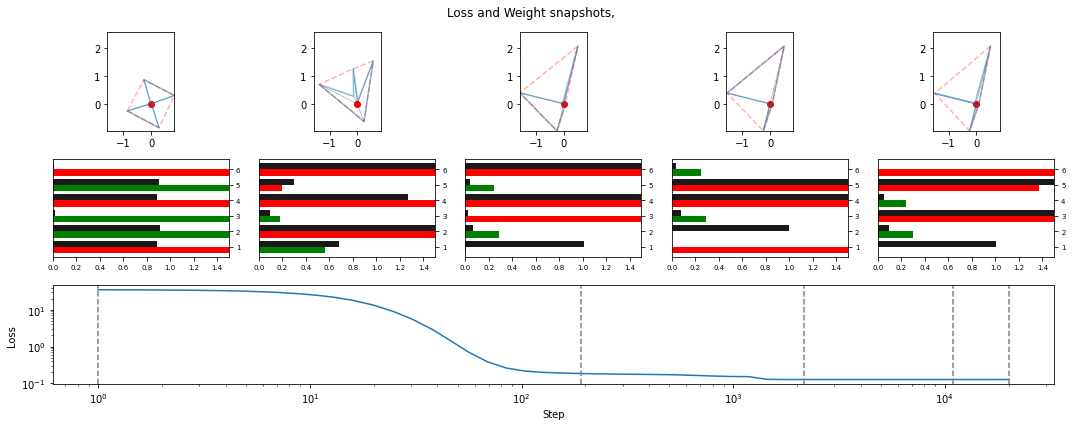

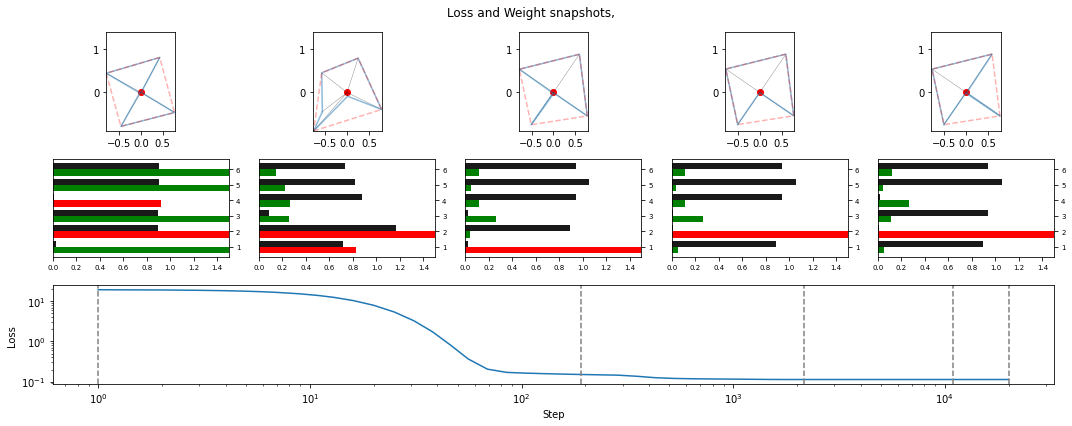

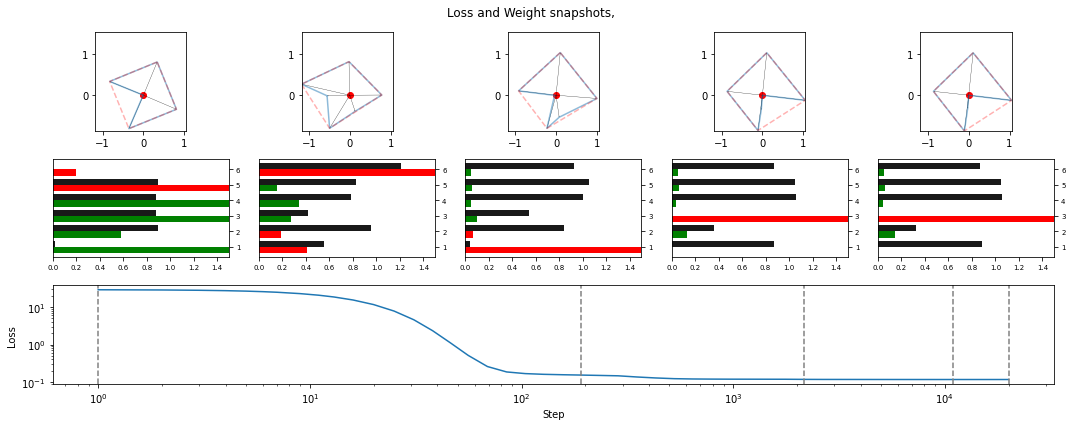

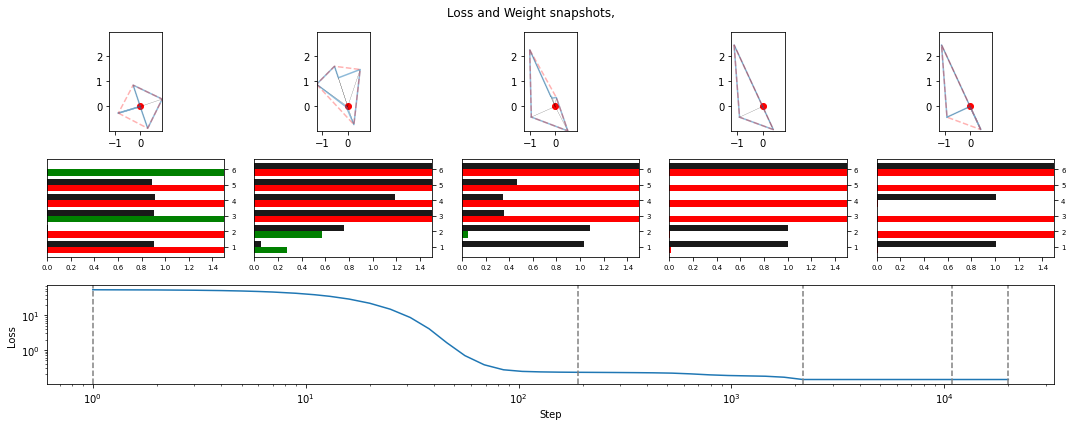

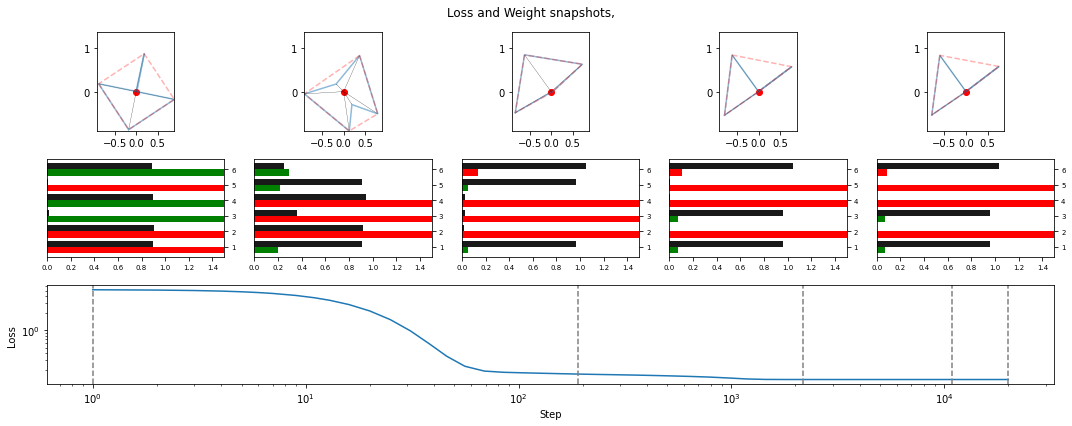

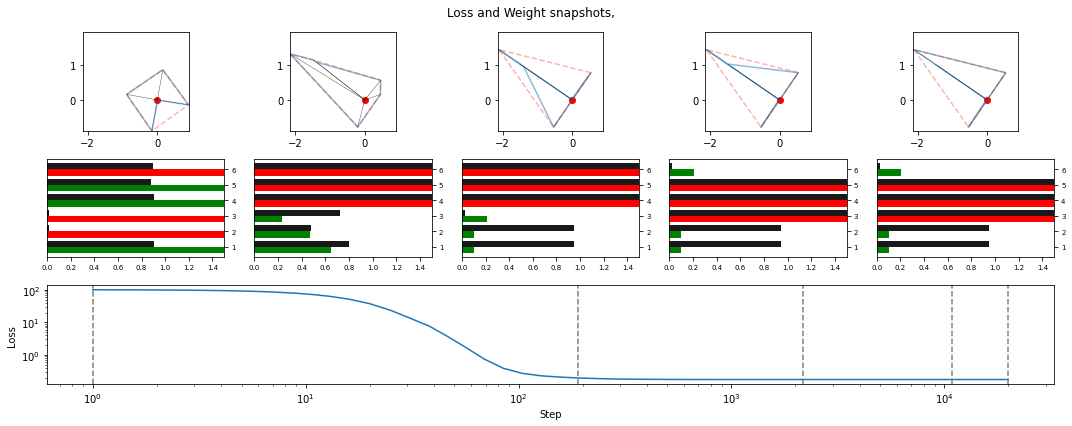

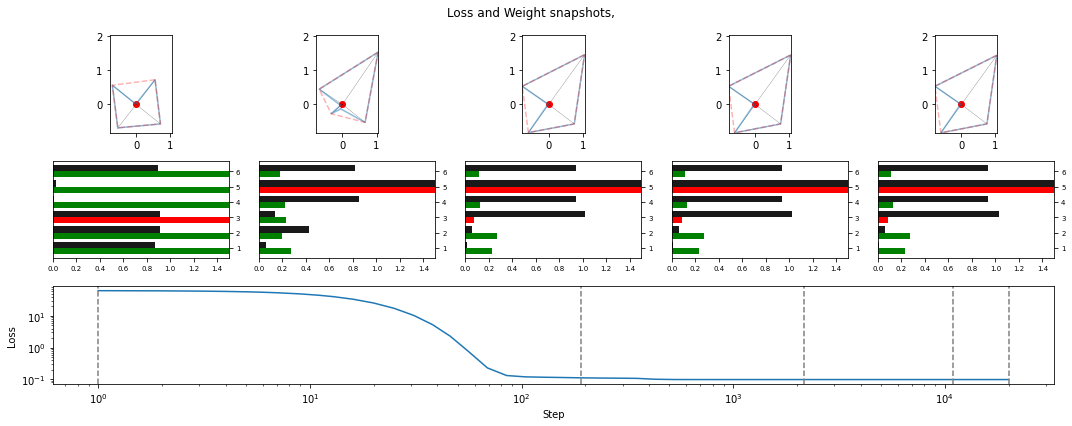

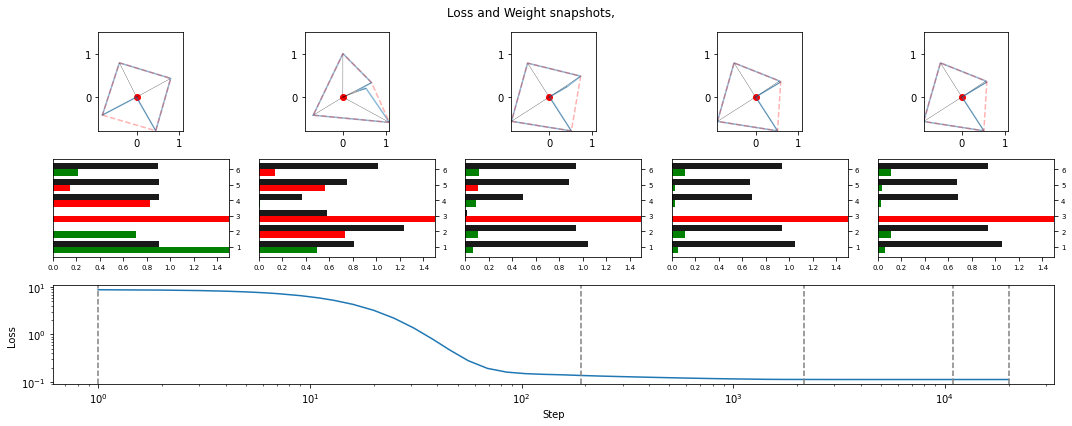

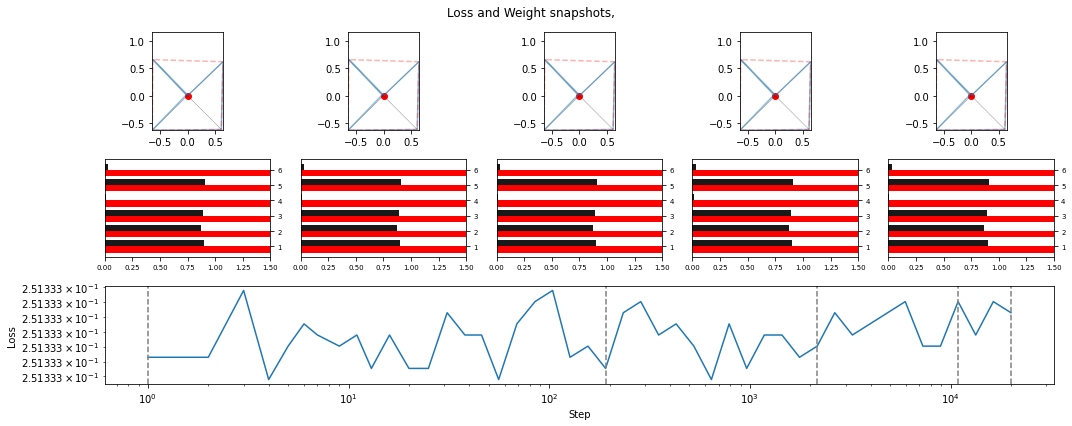

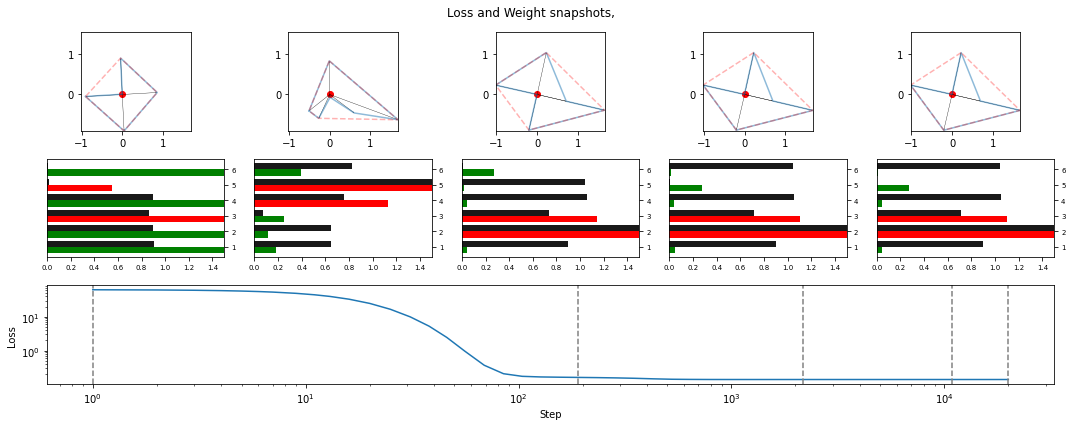

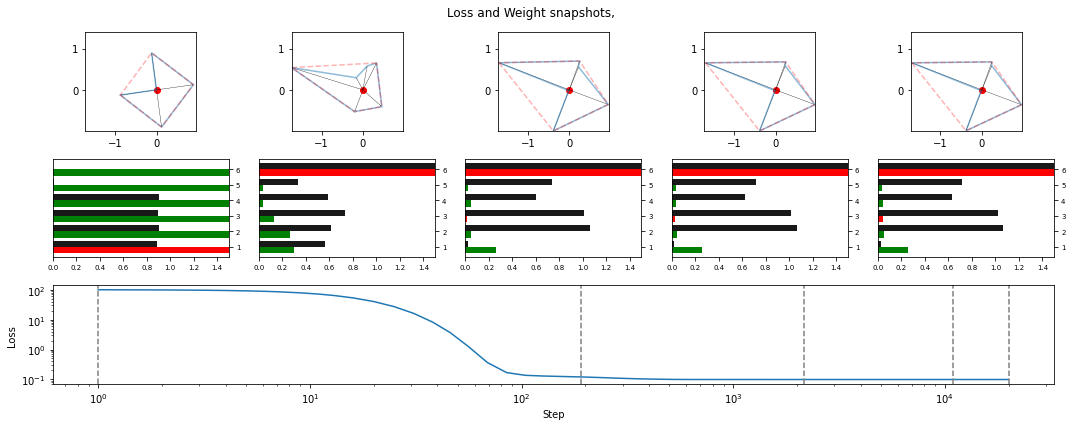

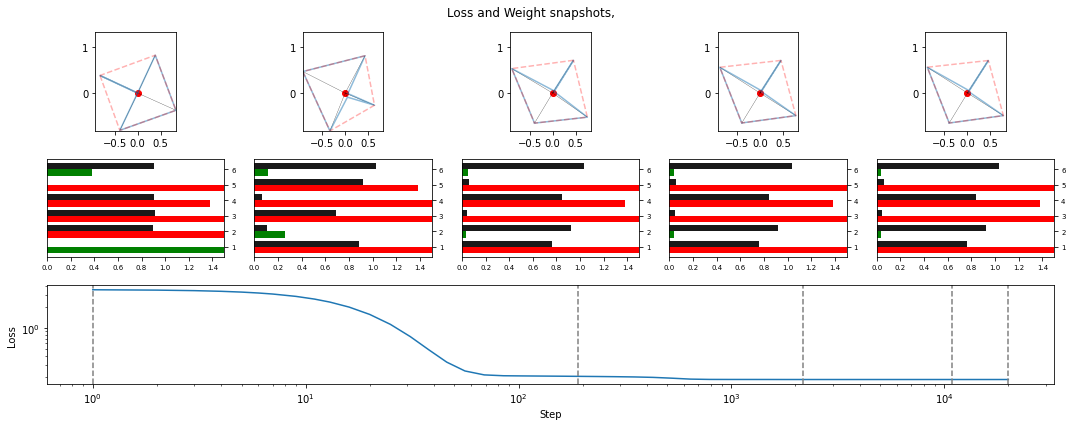

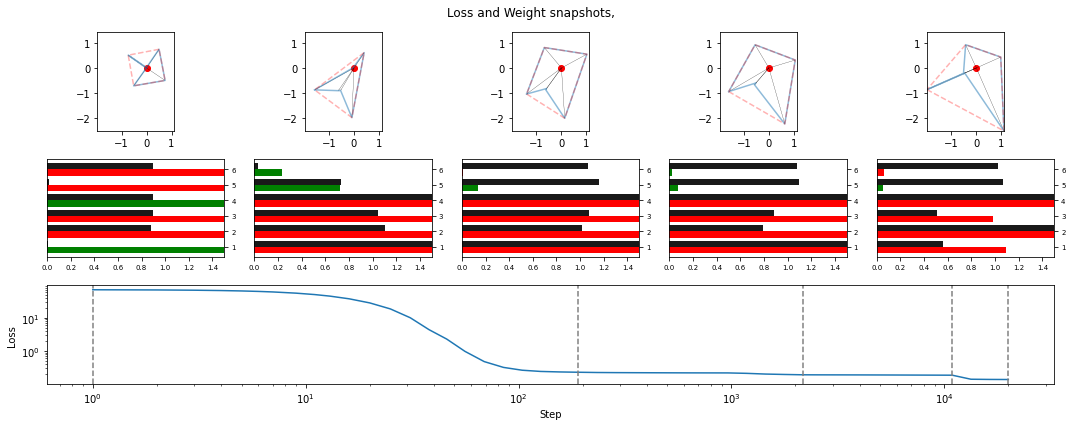

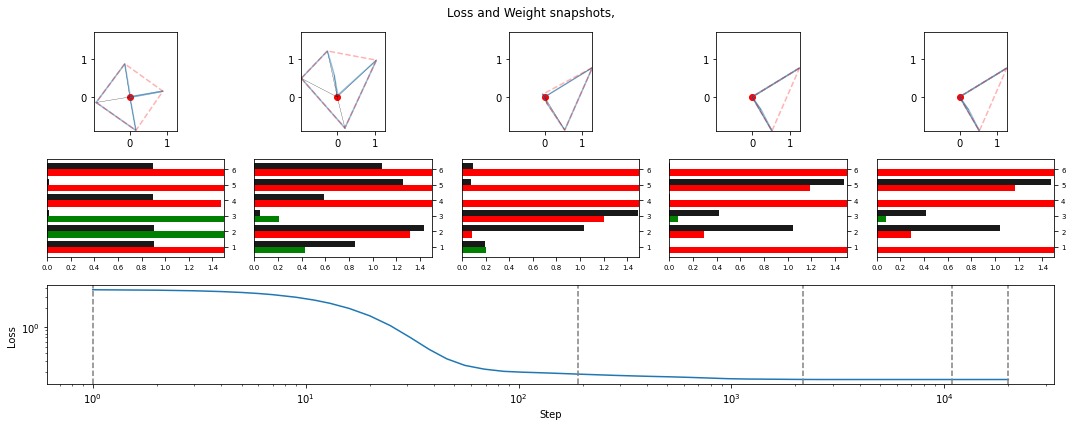

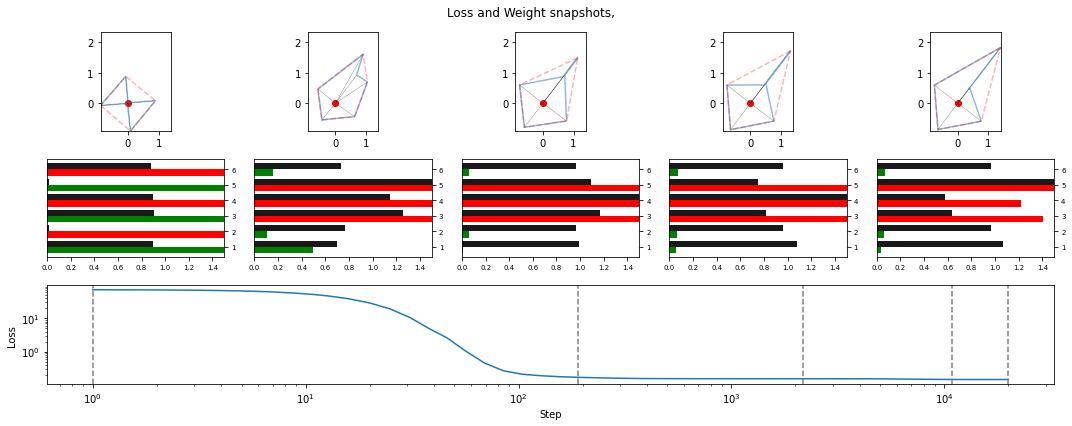

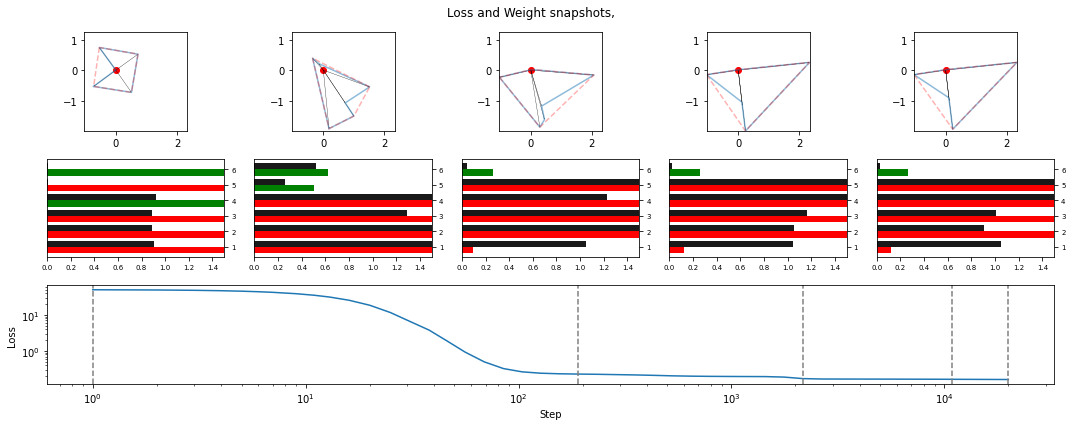

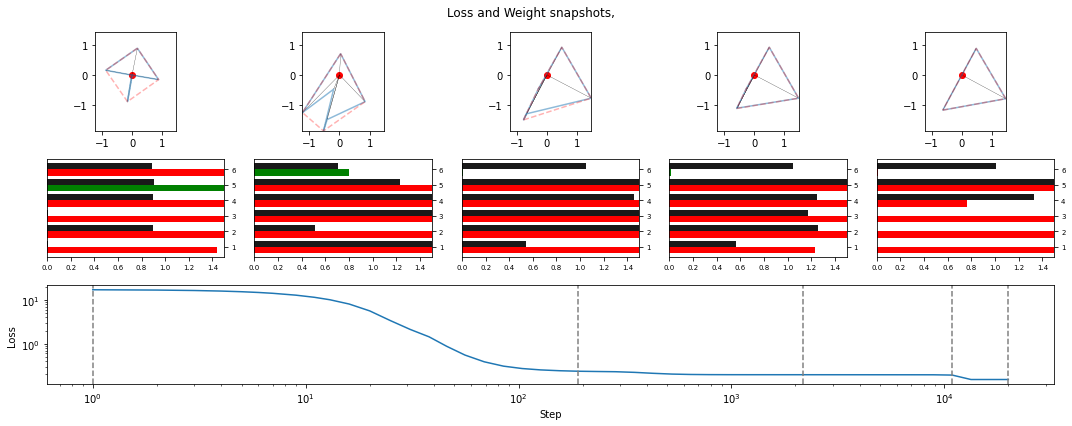

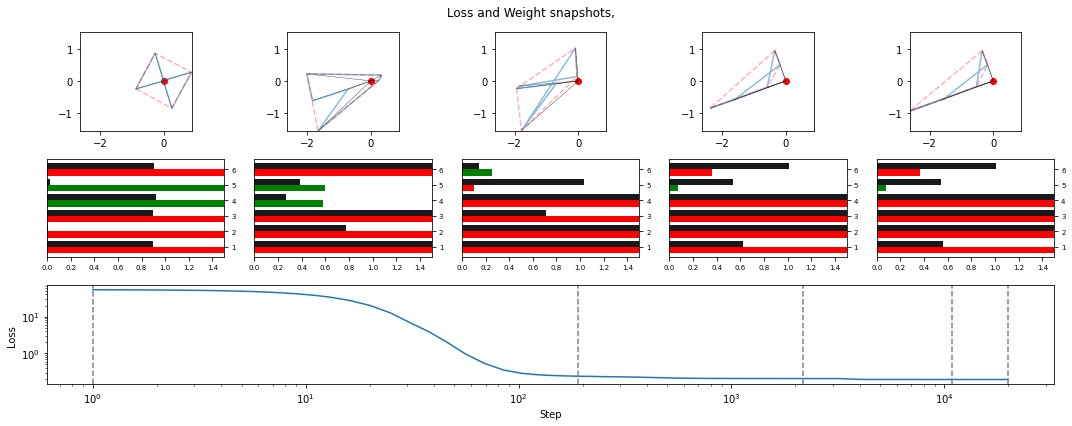

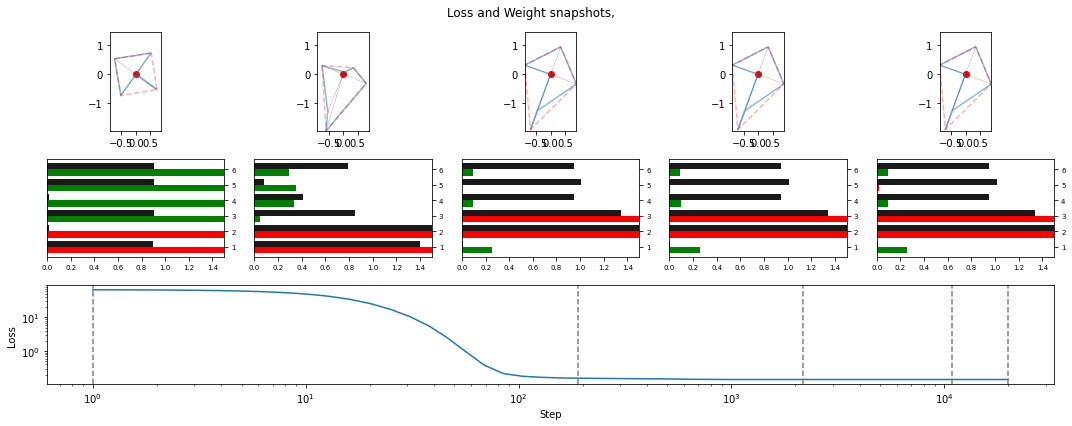

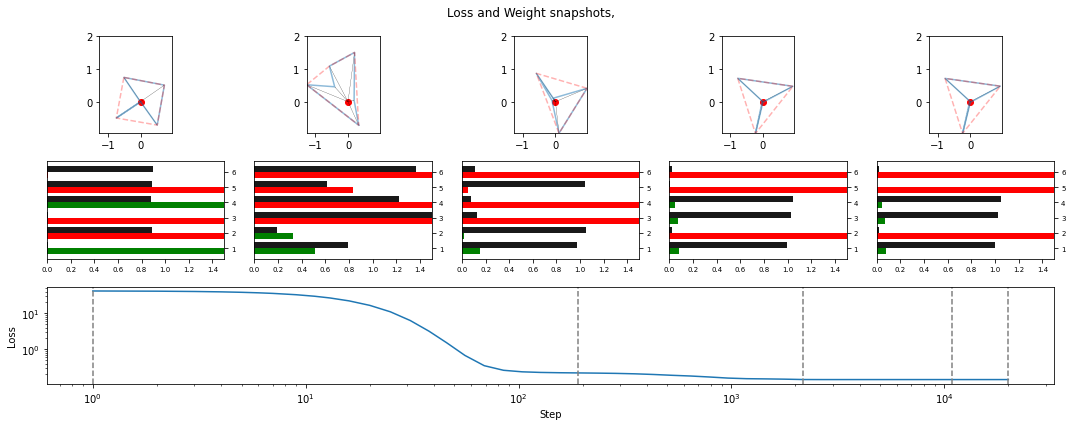

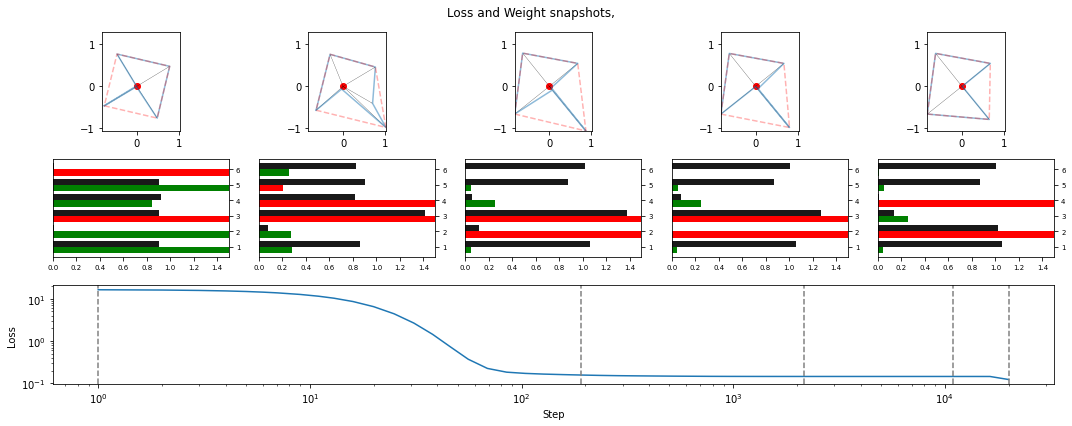

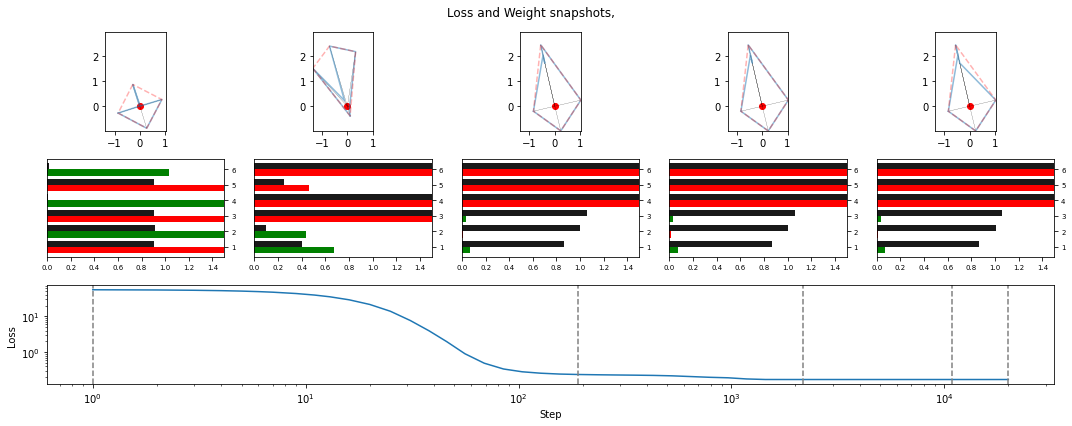

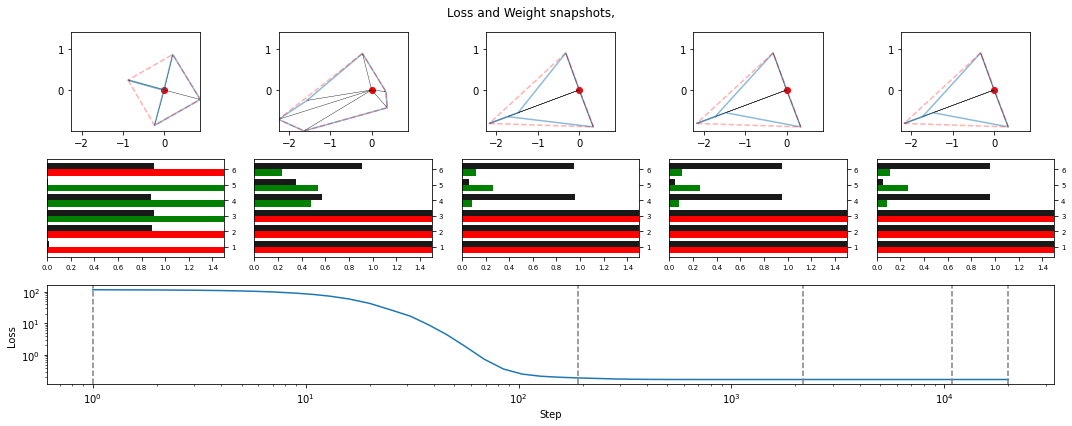

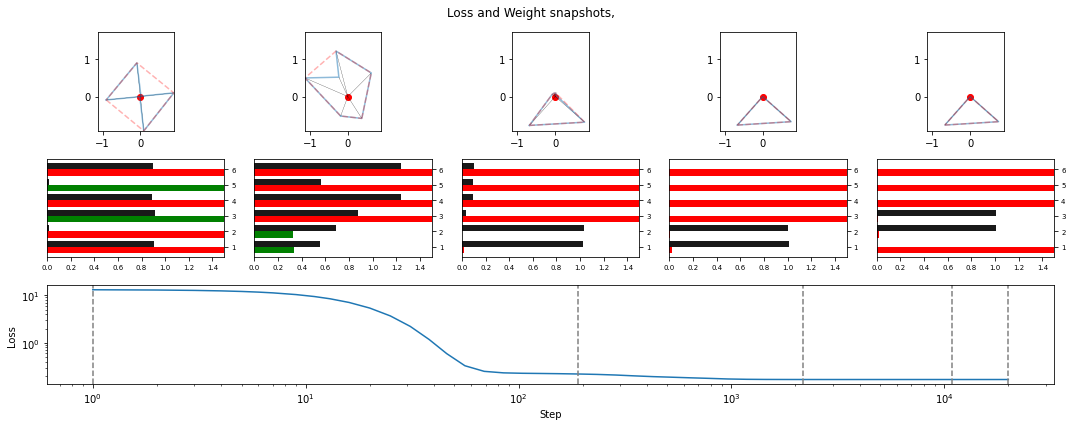

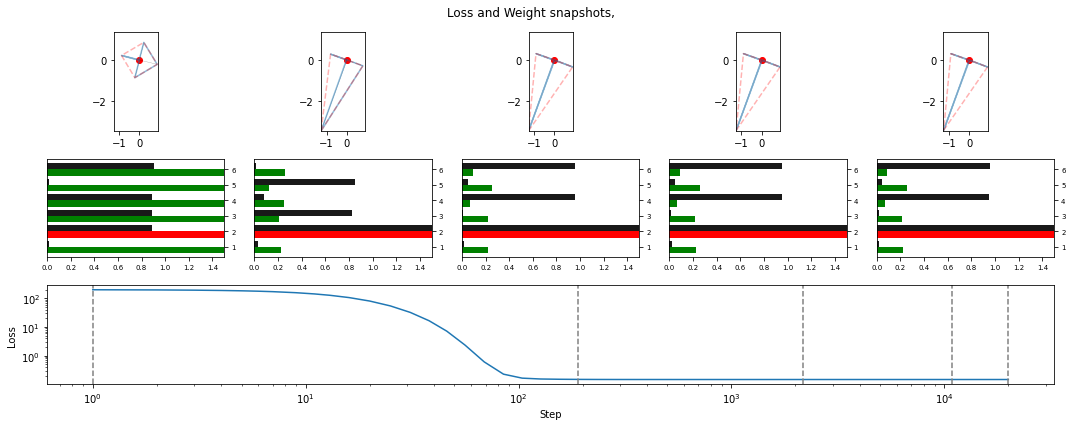

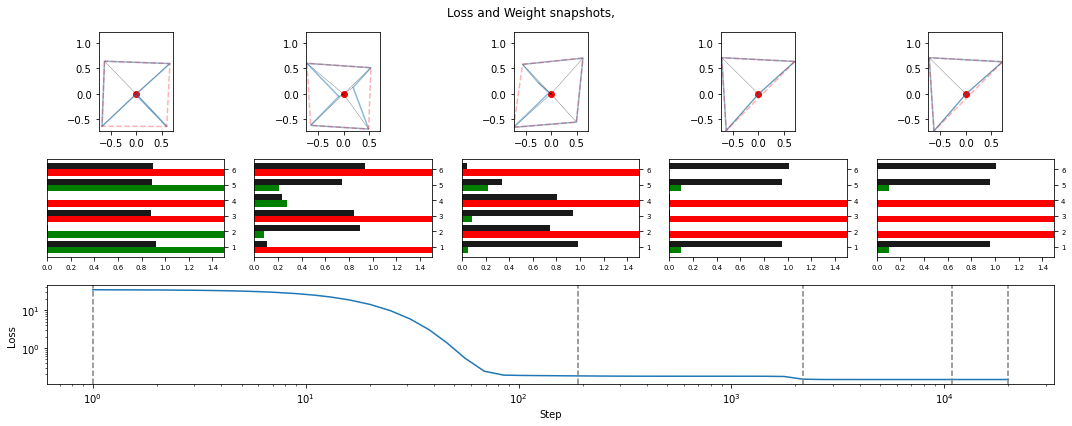

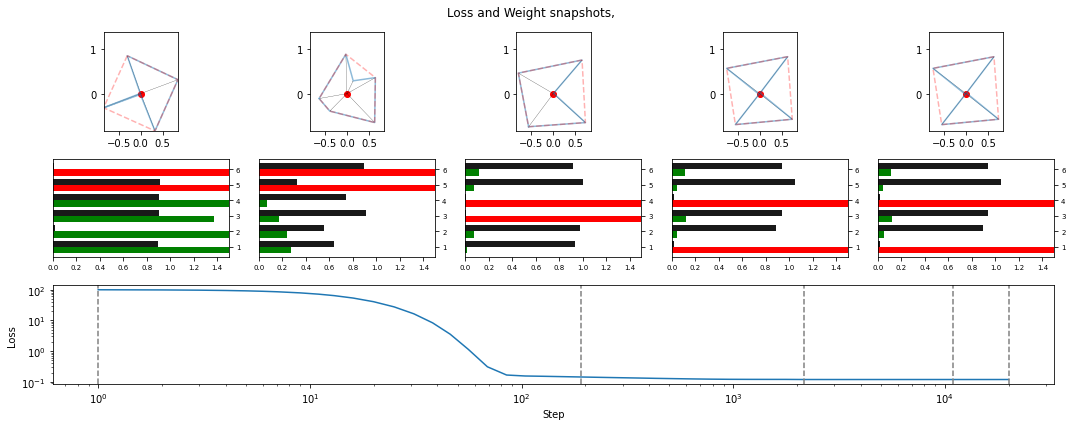

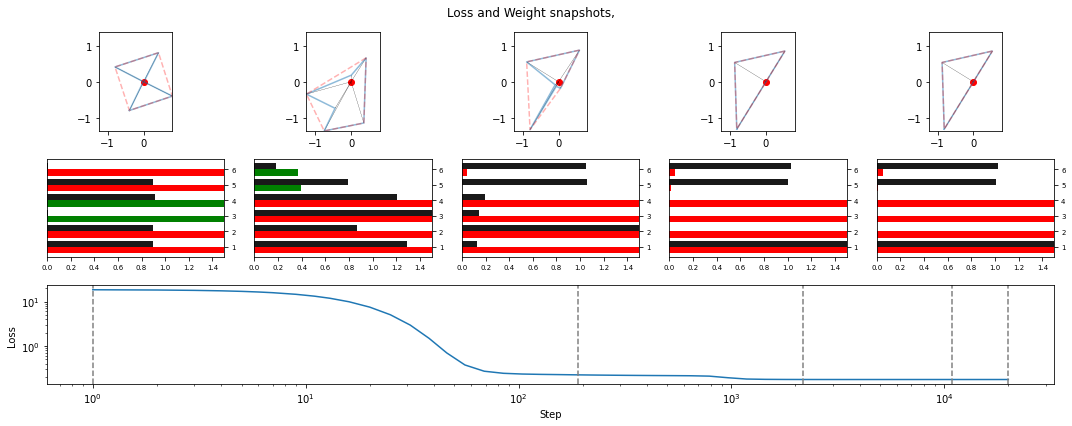

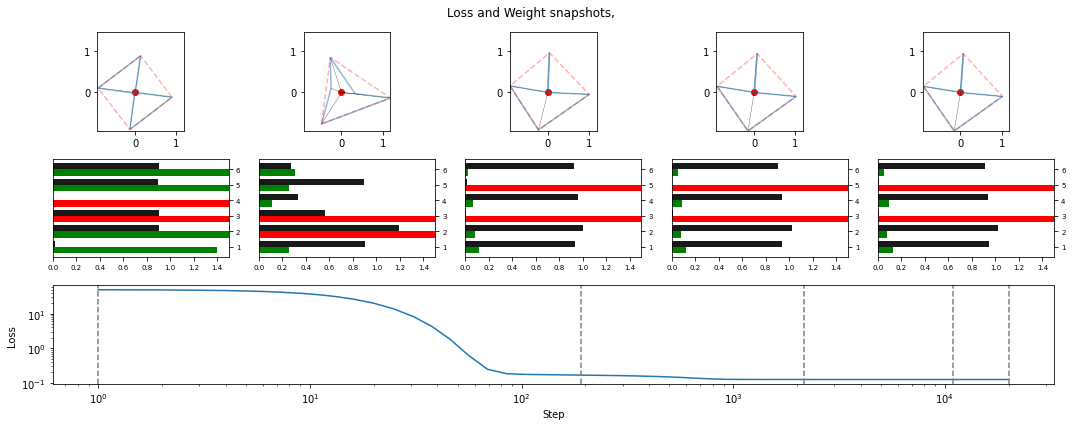

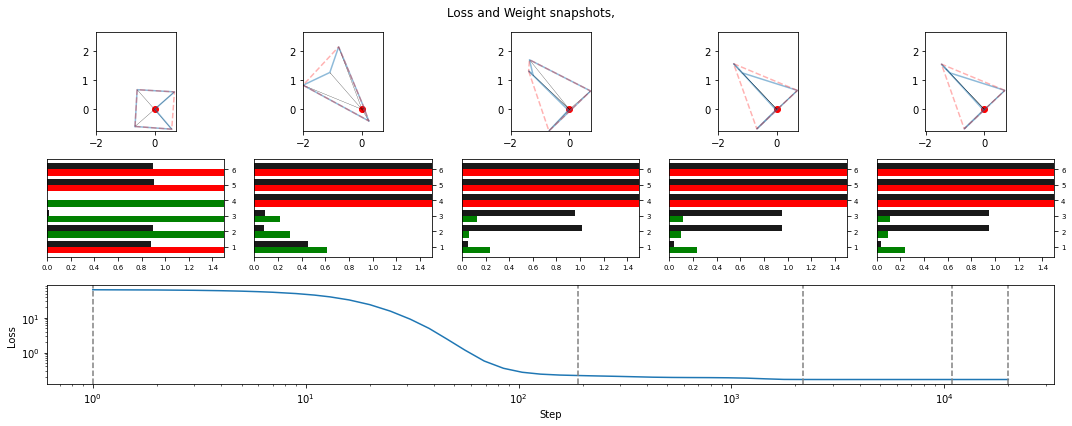

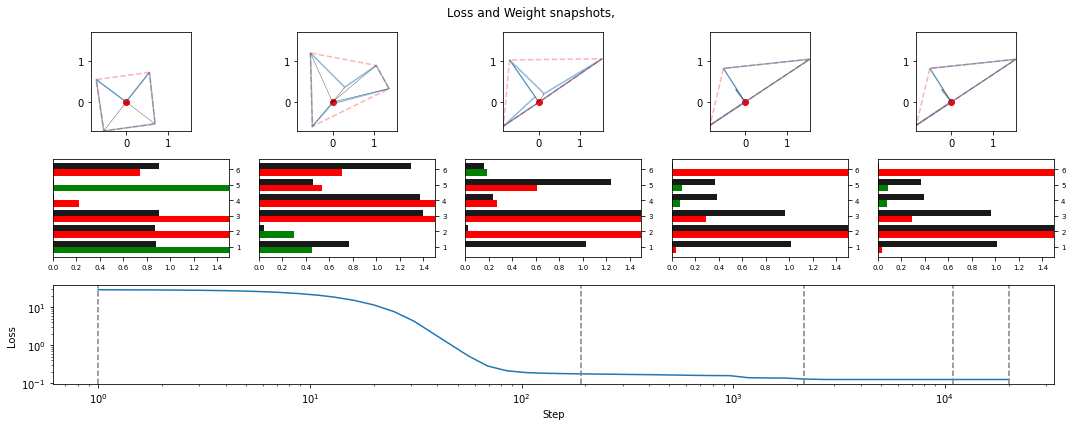

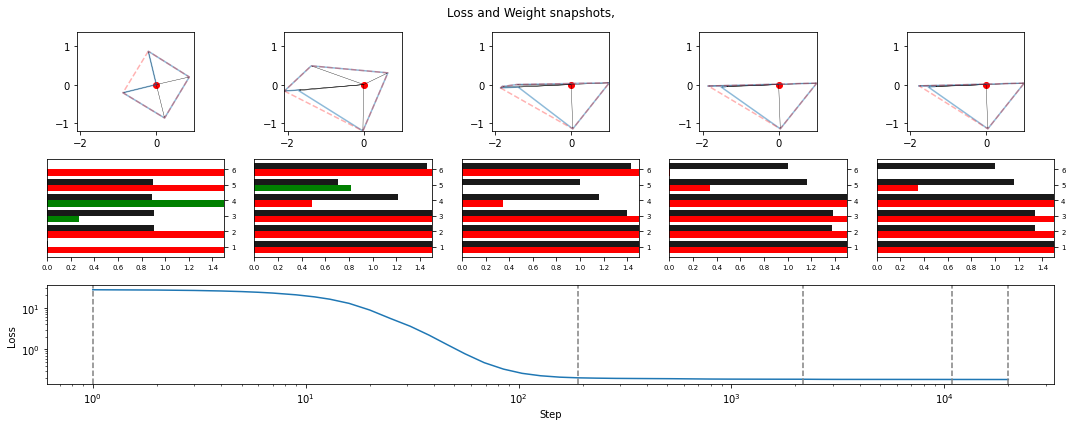

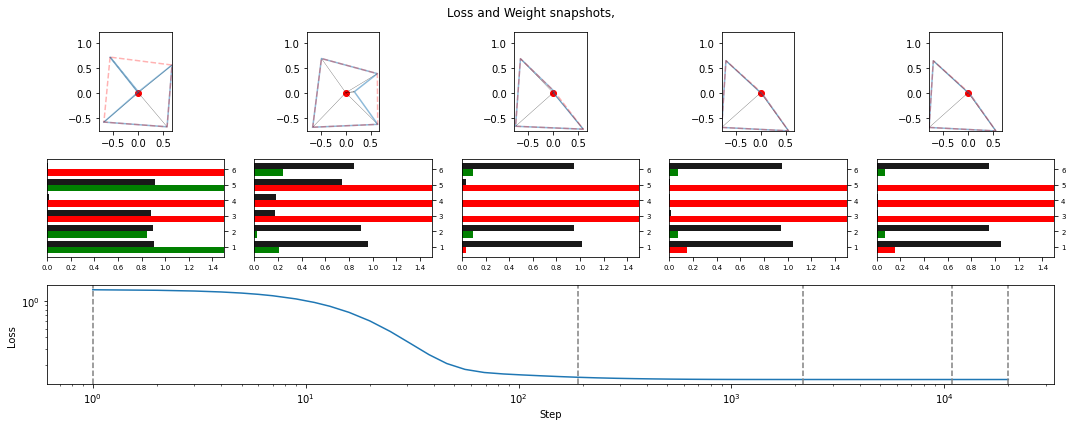

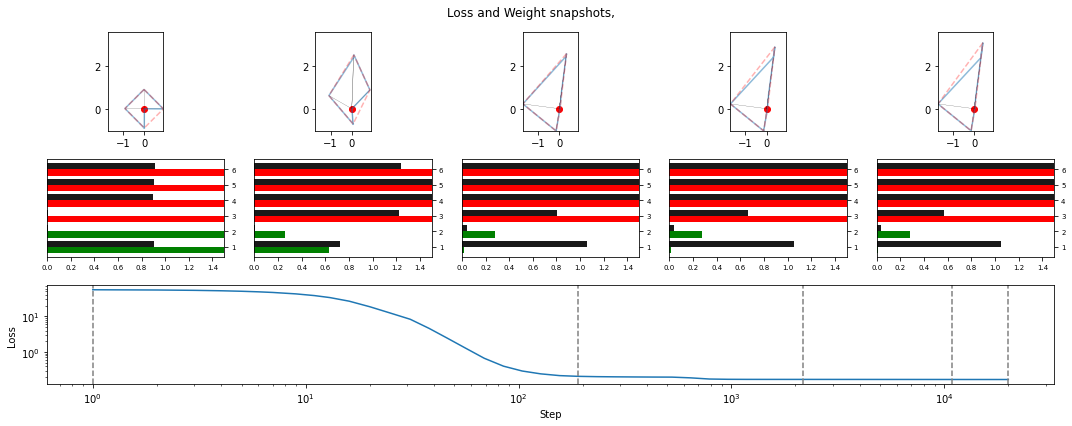

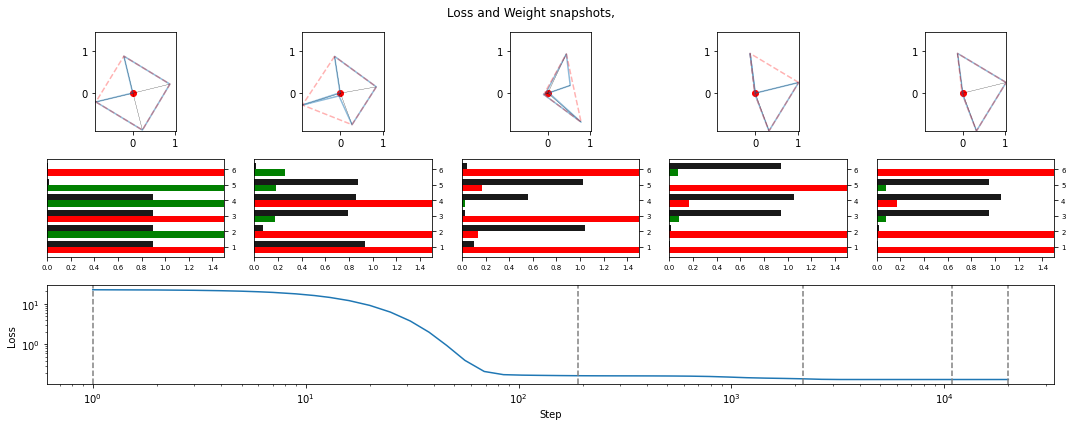

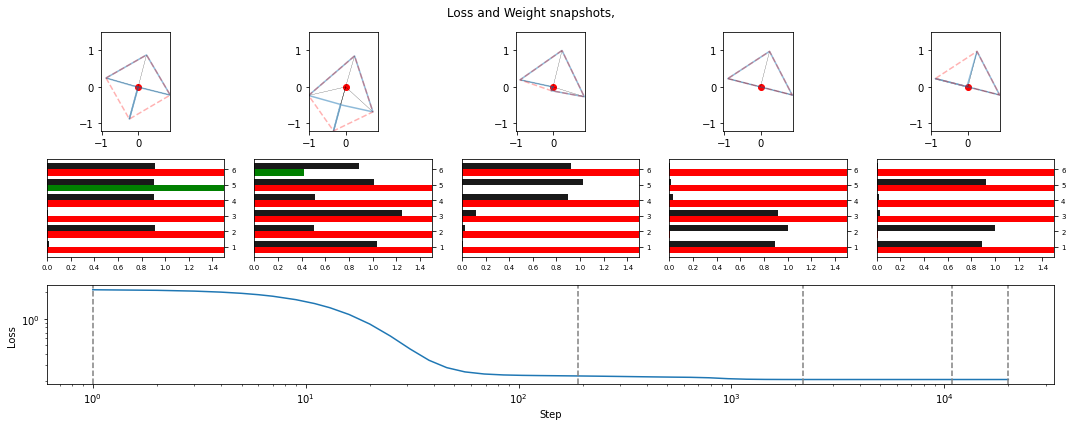

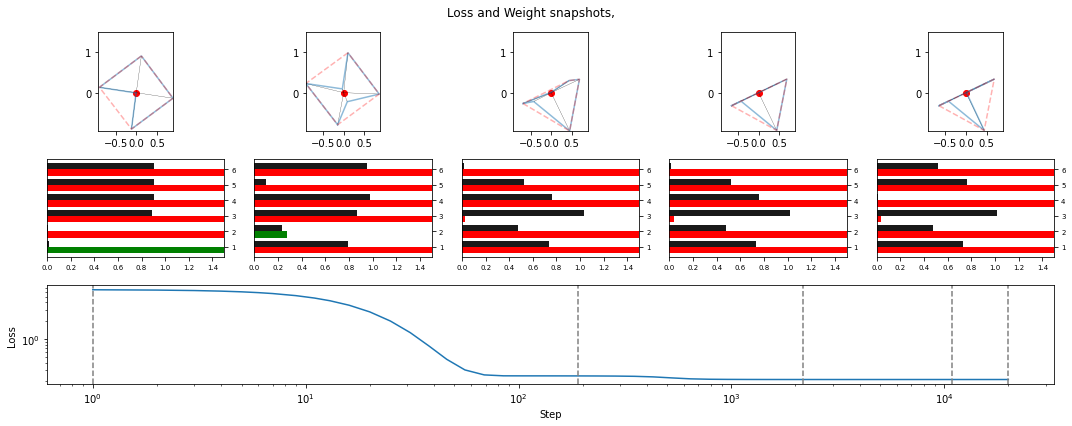

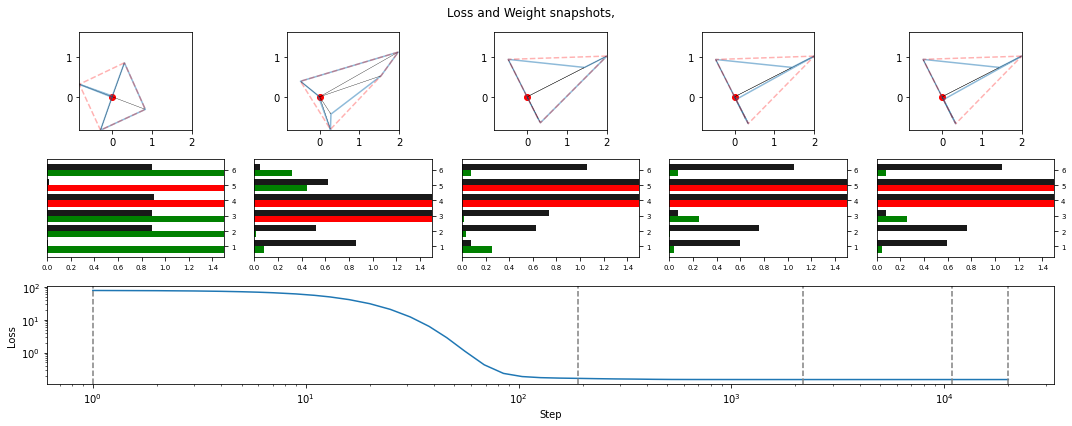

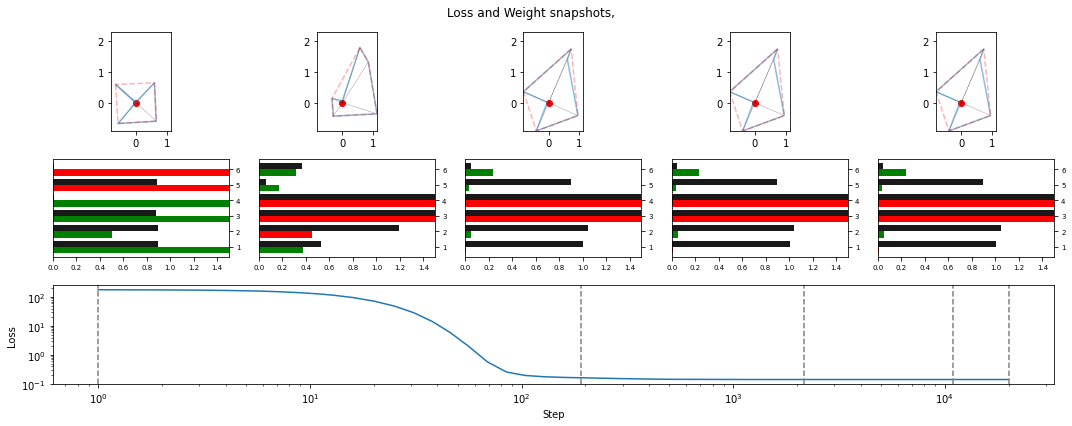

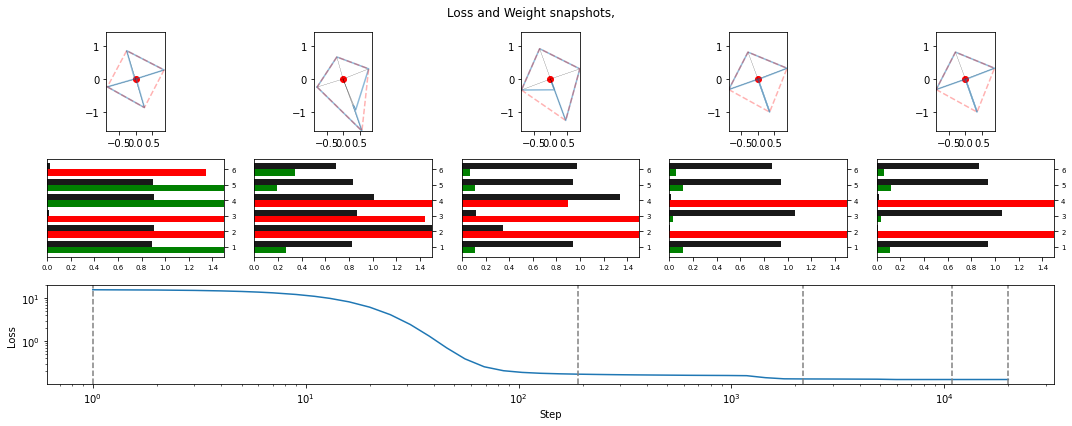

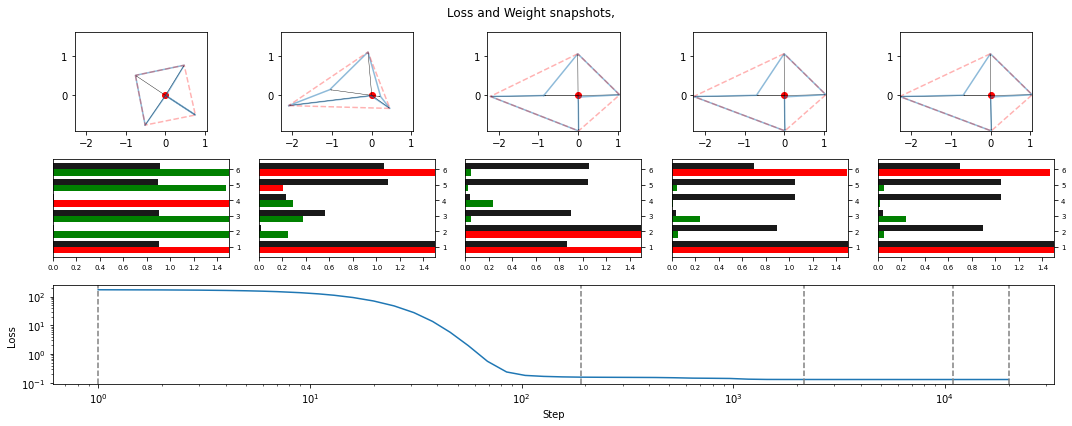

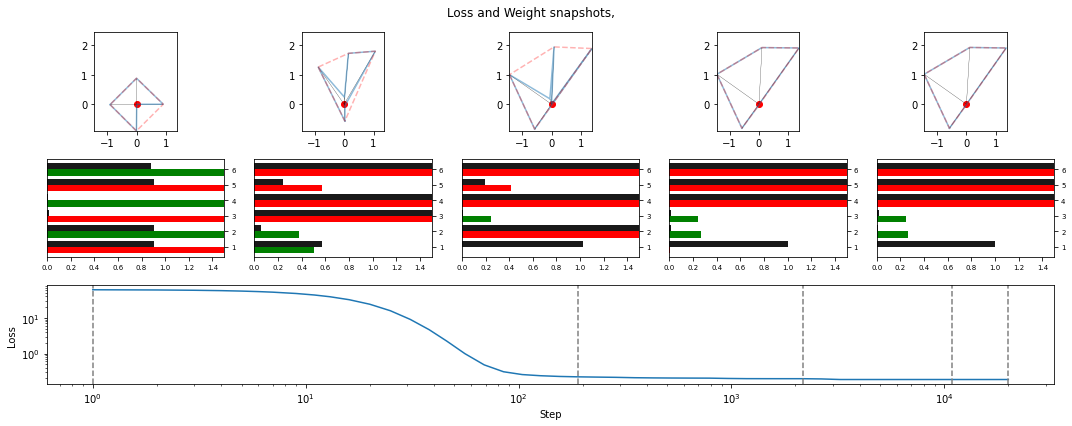

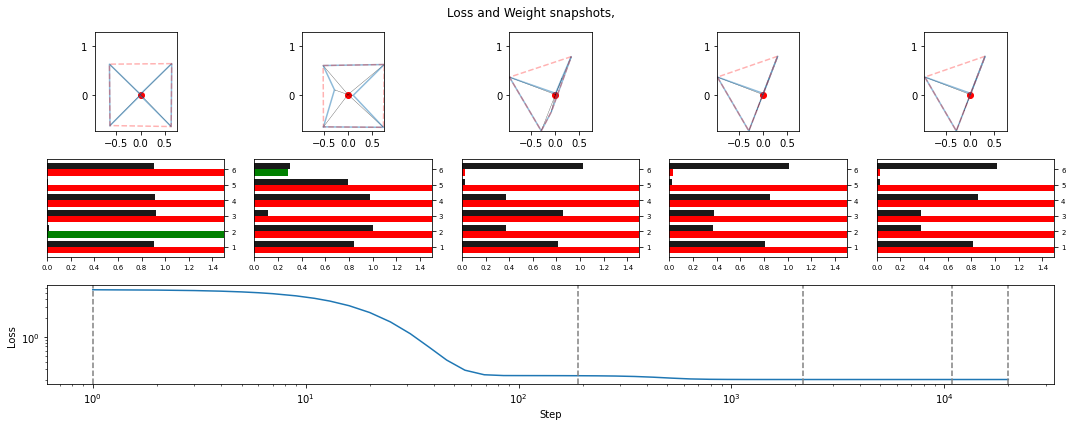

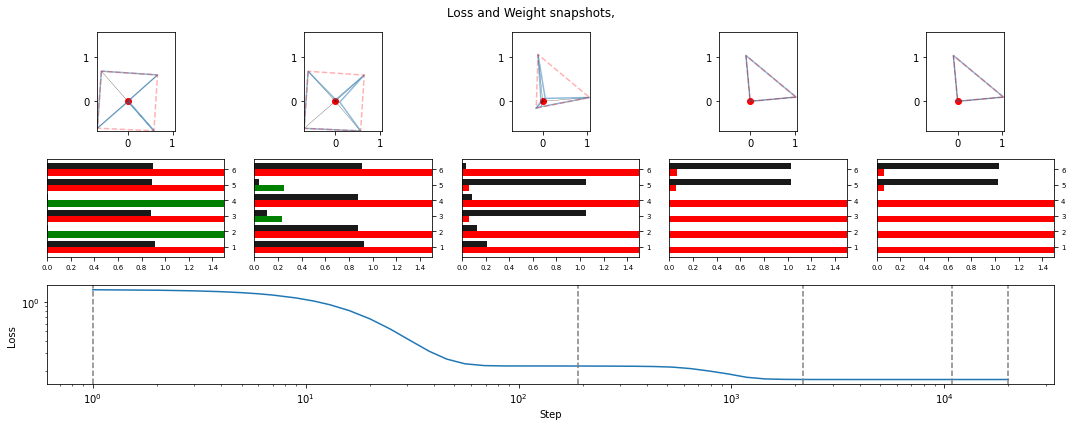

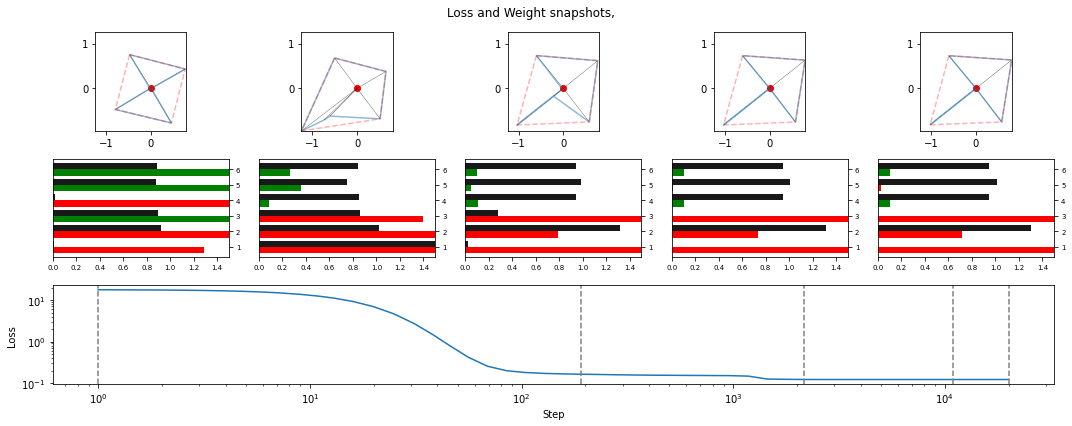

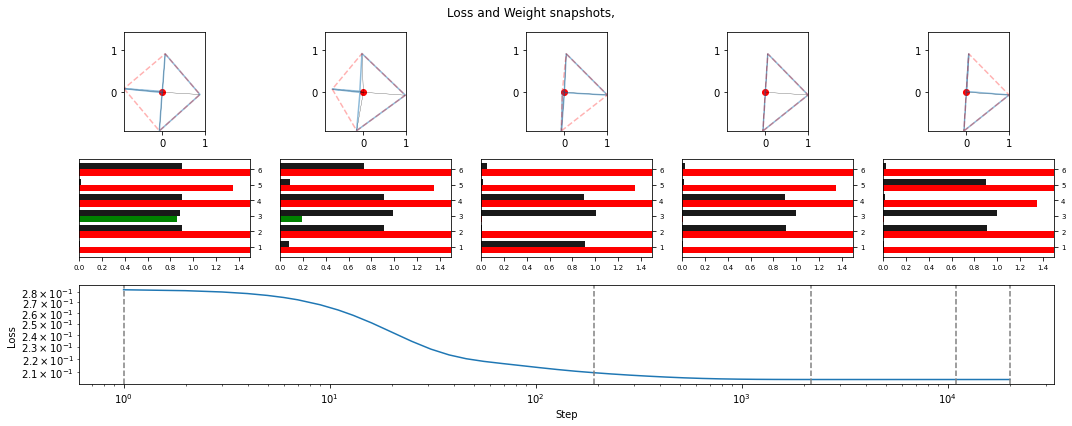

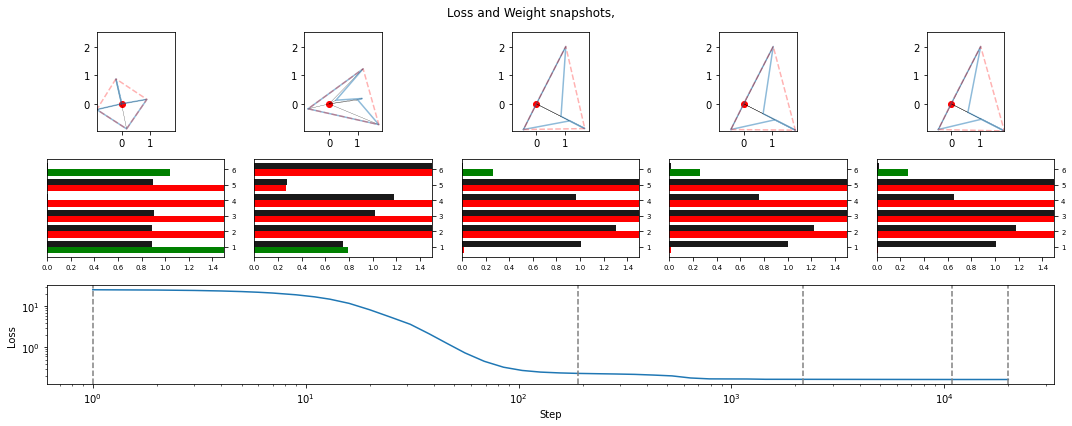

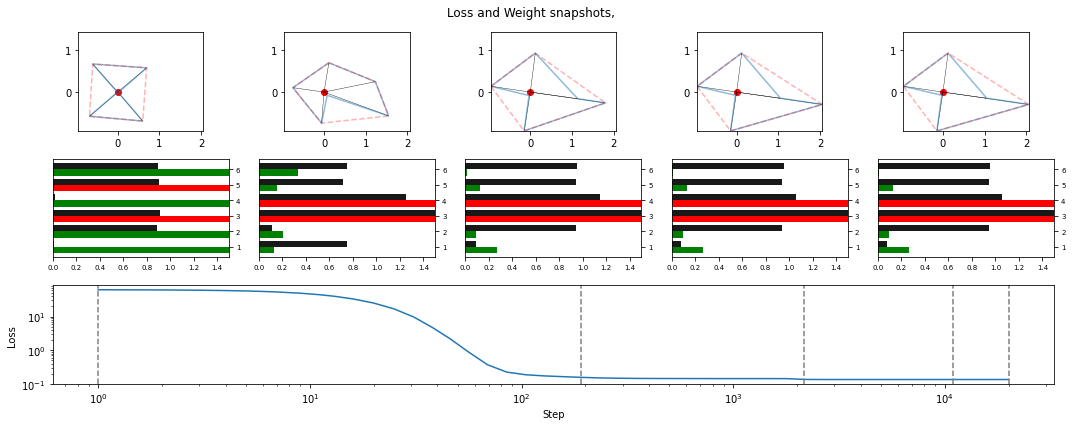

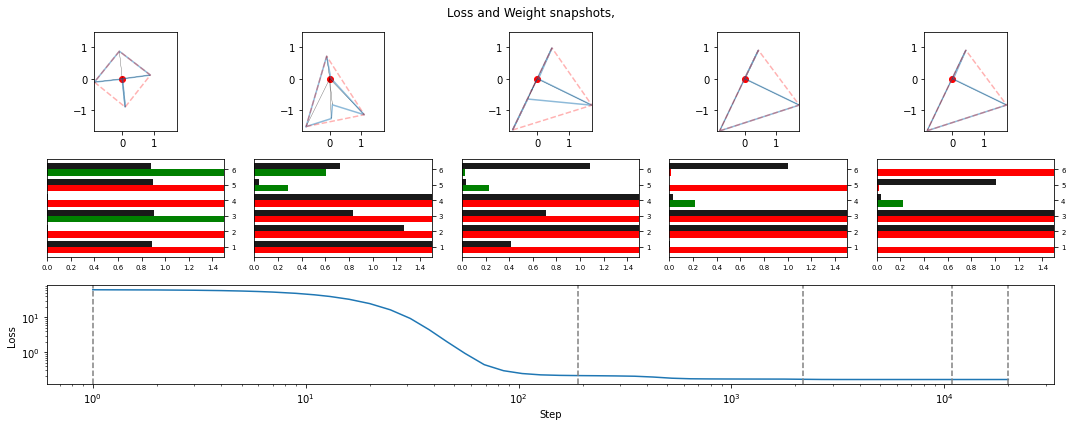

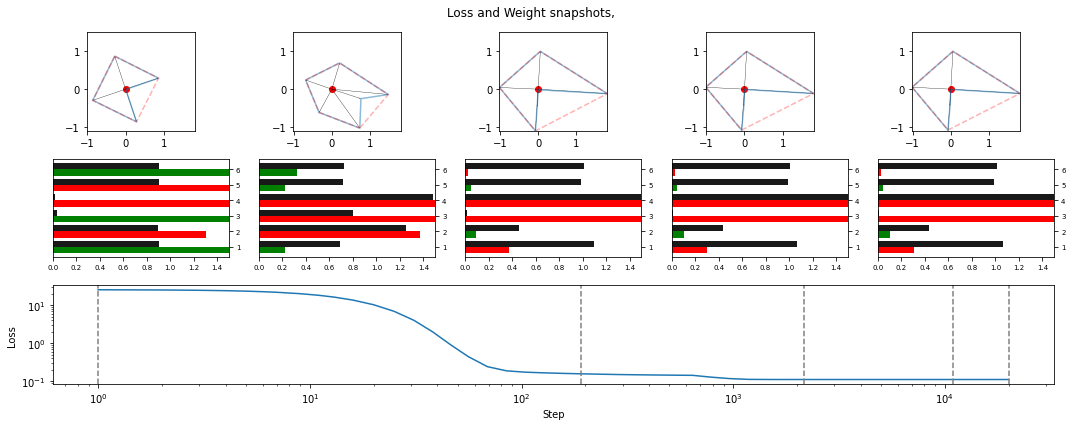

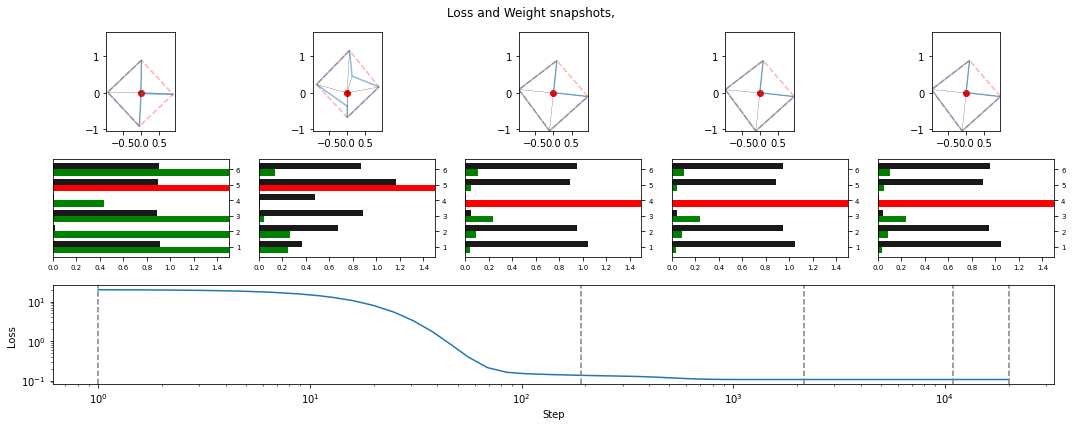

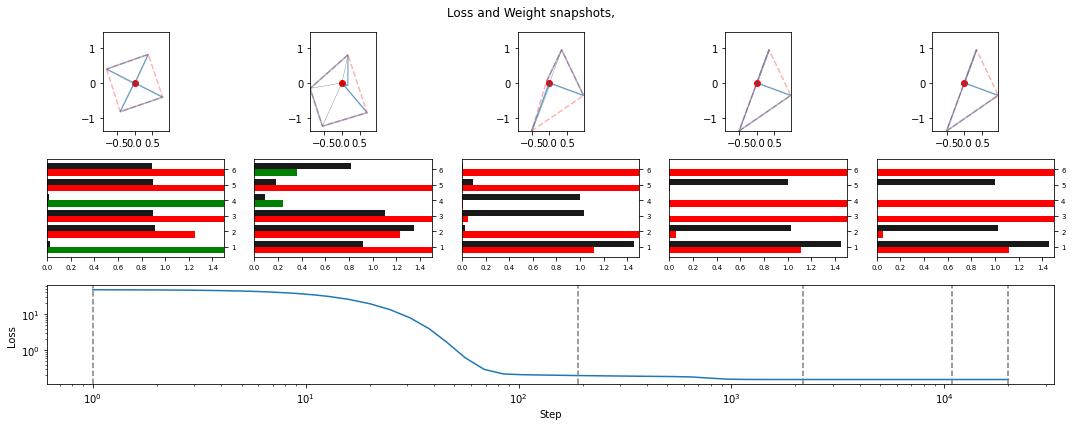

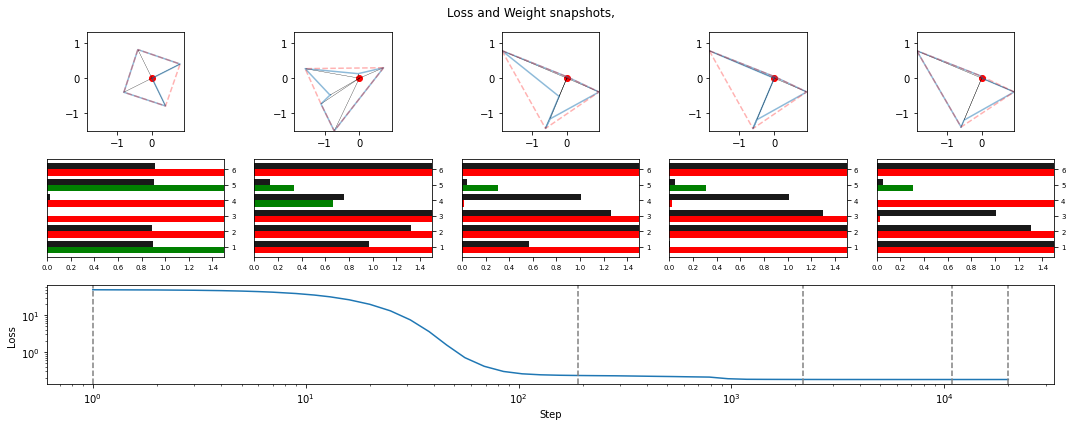

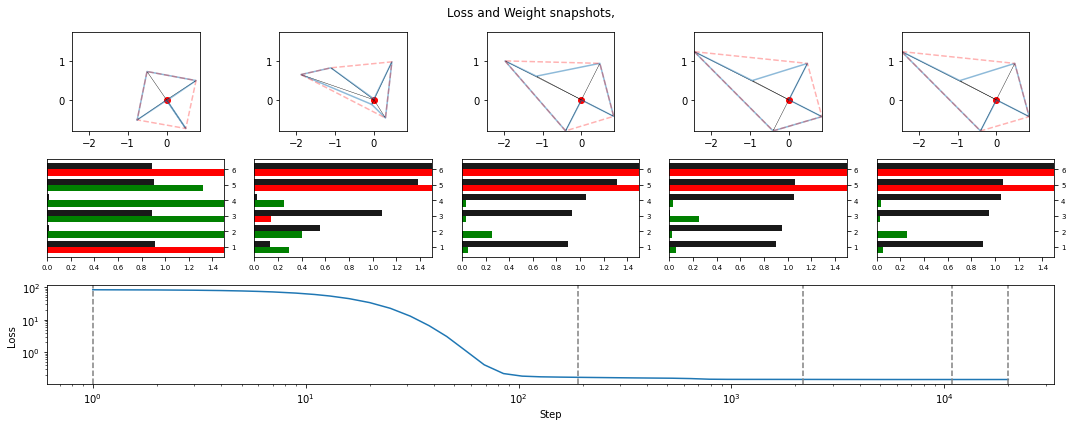

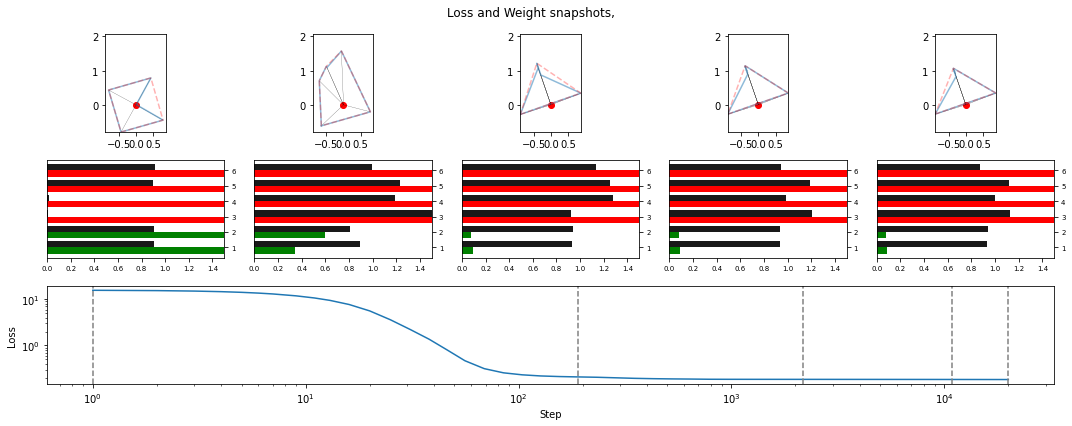

In [147]:
for index in range(len(results)):
    STEPS = results[index]['parameters']['log_ivl']
    if results[index]['parameters']['sparsity'] != 0.75:
        continue
    if results[index]['parameters']['num_samples'] == 10:
        #print(index)
        continue
    #if index > 550:
    #    break
    logs = results[index]['logs']

    losses = [logs.loc[logs['step'] == s, 'loss'].values[0] for s in STEPS]

    NUM_EPOCHS = 20000
    PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, NUM_EPOCHS - 1]]
    PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]
    Ws = [results[index]['weights'][i]['embedding.weight'] for i in PLOT_INDICES]
    biases = [results[index]['weights'][i]['unembedding.bias'] for i in PLOT_INDICES]
    #all_weights = [[results[j]['weights'][i] for i in PLOT_INDICES] for j in range(len(results))]
    plot_losses_and_polygons(STEPS, losses, PLOT_STEPS, Ws, biases)

In [ ]:
for index in range(len(results)):
    STEPS = results[index]['parameters']['log_ivl']
    if results[index]['parameters']['sparsity'] != 0.75:
        continue
    if results[index]['parameters']['num_samples'] == 10:
        #print(index)
        continue
    #if index > 550:
    #    break
    logs = results[index]['logs']

    losses = [logs.loc[logs['step'] == s, 'loss'].values[0] for s in STEPS]

    NUM_EPOCHS = 20000
    PLOT_STEPS = [min(STEPS, key=lambda s: abs(s-i)) for i in [0, 200, 2000, 10000, NUM_EPOCHS - 1]]
    PLOT_INDICES = [STEPS.index(s) for s in PLOT_STEPS]
    Ws = [results[index]['weights'][i]['embedding.weight'] for i in PLOT_INDICES]
    biases = [results[index]['weights'][i]['unembedding.bias'] for i in PLOT_INDICES]
    #all_weights = [[results[j]['weights'][i] for i in PLOT_INDICES] for j in range(len(results))]
    plot_losses_and_polygons(STEPS, losses, PLOT_STEPS, Ws, biases)

In [ ]:
weights = defaultdict(list)
for sparsity in [0,0.25,0.5,0.75,1]:
    
    for result in results:
        if result['parameters']['sparsity'] == sparsity and results[index]['parameters']['num_samples'] == 1000:
            weights[sparsity].append((result['weights']))

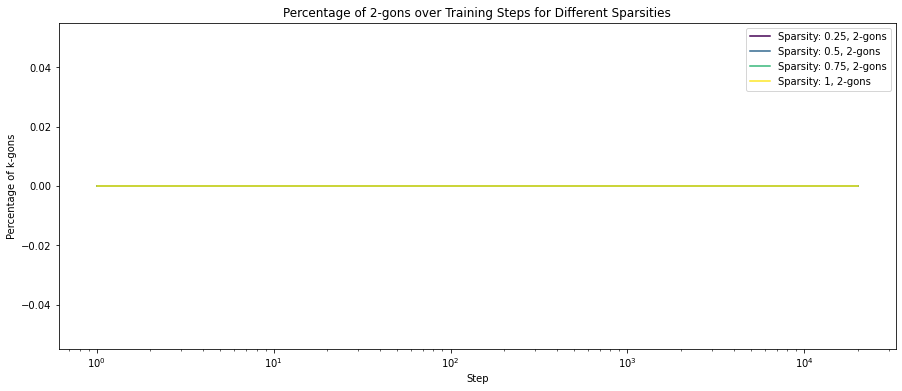

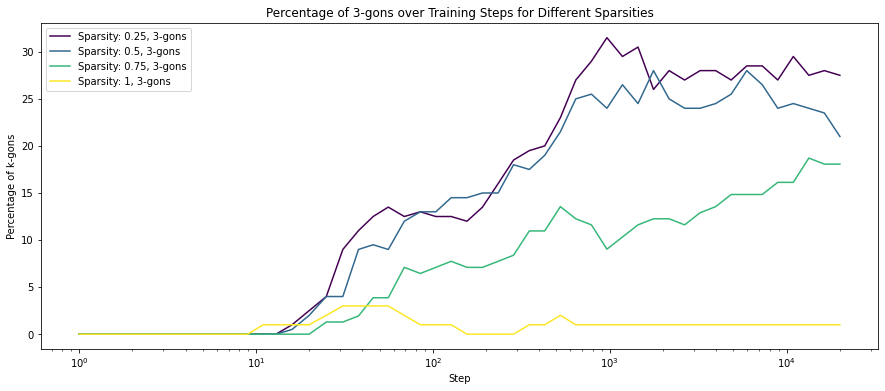

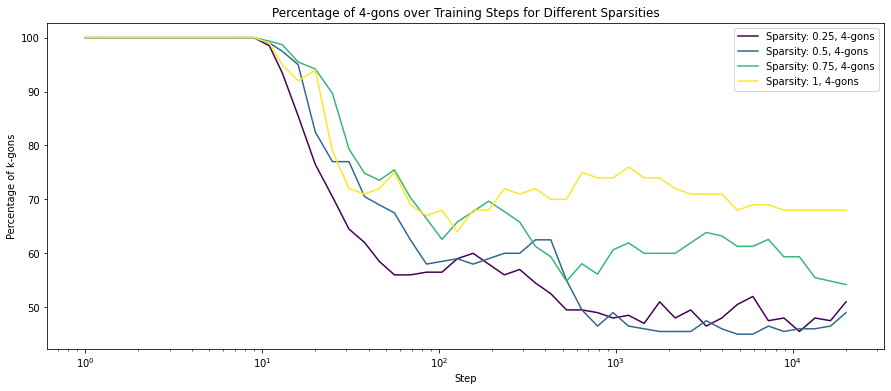

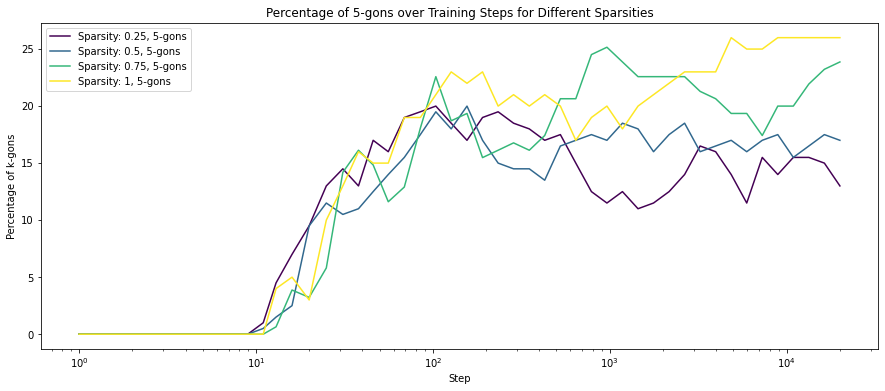

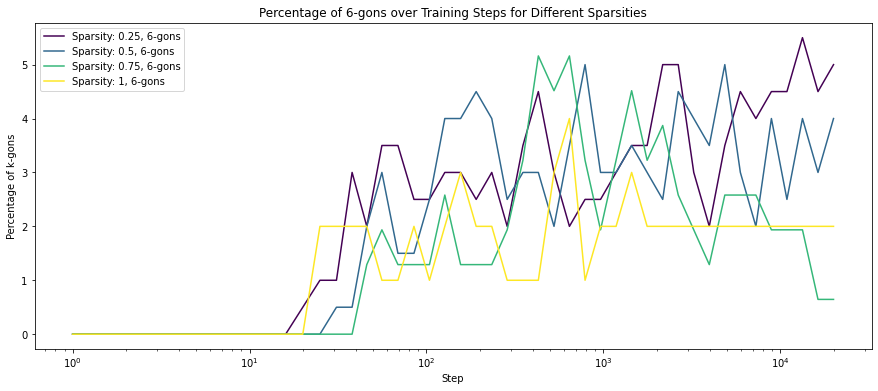

In [195]:
for i in range(2,7):
    plot_percentage_of_kgons_over_time(weights, STEPS, k_values=[i])